  # LIBERO Rollout SR+Speed Benchmark for MiniVLAFastPath





  This notebook runs LIBERO rollout benchmarks for compiled MiniVLA variants.

  ## Setup and Imports

In [1]:
import os

# Keep these as early as possible for offscreen mujoco + prismatic load.
os.environ["PRISMATIC_DATA_ROOT"] = ""
os.environ["MUJOCO_GL"] = "egl"
os.environ["PYOPENGL_PLATFORM"] = "egl"
os.environ["TOKENIZERS_PARALLELISM"] = "false"
os.environ["CUDA_VISIBLE_DEVICES"] = "0"
# os.environ["MUJOCO_EGL_DEVICE_ID"] = "3"


In [2]:
from dataclasses import dataclass
from pathlib import Path
from typing import Dict, List, Optional, Tuple, Union

import numpy as np
import torch
import tqdm
import sys
sys.path.append("/mnt/scratch/aagouzoul/ovla/openvla-mini")
from libero.libero import benchmark

from experiments.robot.libero.libero_utils import (
    get_libero_dummy_action,
    get_libero_env,
    get_libero_image,
    quat2axisangle,
    save_rollout_video,
)
from experiments.robot.robot_utils import (
    get_image_resize_size,
    get_model,
    invert_gripper_action,
    normalize_gripper_action,
    set_seed_everywhere,
)
from experiments.specdec.minivla_fastpath import MiniVLAFastPath



2026-01-10 13:14:51.974299: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2026-01-10 13:14:52.011146: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2026-01-10 13:14:52.011180: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2026-01-10 13:14:52.012372: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2026-01-10 13:14:52.018312: I tensorflow/core/platform/cpu_feature_guar

  ## Helper Functions

In [3]:
def _select_unnorm_key(model, desired: str) -> str:
    """Match common repo logic for picking an available unnorm key."""
    if not hasattr(model, "norm_stats") or not isinstance(getattr(model, "norm_stats"), dict):
        return desired
    if desired in model.norm_stats:
        return desired
    if f"{desired}_no_noops" in model.norm_stats:
        return f"{desired}_no_noops"
    if desired.replace("_no_noops", "") in model.norm_stats:
        return desired.replace("_no_noops", "")
    # Fallback to first key to avoid crashing in quick benchmarks.
    # print in that case
    first_key = next(iter(model.norm_stats.keys()))
    print(f"WARNING: No unnorm key found for {desired}, using first available key: {first_key}")
    return first_key



In [4]:
def _max_steps_for_suite(task_suite_name: str) -> int:
    if task_suite_name == "libero_spatial":
        return 220
    if task_suite_name == "libero_object":
        return 280
    if task_suite_name == "libero_goal":
        return 300
    if task_suite_name == "libero_10":
        return 520
    if task_suite_name == "libero_90":
        return 400
    # Safe-ish fallback.
    return 400



In [5]:
def _summarize_ms(xs: List[float]) -> Dict[str, float]:
    if len(xs) == 0:
        return {"n": 0}
    arr = np.asarray(xs, dtype=np.float64)
    return {
        "n": float(arr.size),
        "mean_ms": float(arr.mean()),
        "std_ms": float(arr.std()),
        "min_ms": float(arr.min()),
        "p50_ms": float(np.percentile(arr, 50)),
        "p90_ms": float(np.percentile(arr, 90)),
        "p95_ms": float(np.percentile(arr, 95)),
        "max_ms": float(arr.max()),
        "hz": float(1000.0 / arr.mean()) if arr.mean() > 0 else float("nan"),
    }



  ## Configuration

In [6]:
@dataclass
class EvalConfig:
    # Model
    model_family: str = "prismatic"
    hf_token: Union[str, Path] = Path(".hf_token")
    pretrained_checkpoint: Union[str, Path] = "Stanford-ILIAD/minivla-libero90-prismatic"
    center_crop: bool = True

    # LIBERO
    task_suite_name: str = "libero_90"
    task_id: int = 0
    num_tasks: int = 1
    num_trials_per_task: int = 1
    num_steps_wait: int = 10
    max_steps_override: Optional[int] = None
    seed: int = 7

    # FastPath
    use_fastpath: bool = True
    compile_llm: bool = False
    compile_vision: bool = False
    compile_mode: str = "default"
    compile_mode_vision: Optional[str] = None  # if None, uses compile_mode; otherwise independent
    warmup_policy_calls: int = 1  # warmup calls per task before timing

    # Logging / stats
    show_progress: bool = True
    save_video: bool = False  # Save a local MP4 replay using `save_rollout_video` (no wandb).



  ## Run Benchmark

In [7]:
def run(cfg: EvalConfig) -> None:
    assert cfg.model_family == "prismatic", "This benchmark is for MiniVLA (prismatic) only."
    assert cfg.num_trials_per_task >= 1
    assert cfg.num_tasks >= 1

    set_seed_everywhere(cfg.seed)

    # Load model
    cfg.unnorm_key = cfg.task_suite_name  # expected by `get_model` helpers in this repo
    model = get_model(cfg)
    cfg.unnorm_key = _select_unnorm_key(model, cfg.task_suite_name)

    resize_size = get_image_resize_size(cfg)
    env_resolution = resize_size  # matches `run_libero_eval.py` for prismatic

    # Prepare task suite
    benchmark_dict = benchmark.get_benchmark_dict()
    task_suite = benchmark_dict[cfg.task_suite_name]()
    n_tasks = task_suite.n_tasks
    task_ids = list(range(cfg.task_id, min(cfg.task_id + cfg.num_tasks, n_tasks)))

    # Initialize fastpath once (keeps compilation one-time); update instruction per-task.
    fast: Optional[MiniVLAFastPath] = None

    total_episodes = 0
    total_successes = 0
    all_policy_gpu_ms: List[float] = []

    # CUDA timing helpers
    assert torch.cuda.is_available(), "CUDA required for accurate GPU timing"
    start_ev = torch.cuda.Event(enable_timing=True)
    end_ev = torch.cuda.Event(enable_timing=True)

    # Track compilation time separately (happens once on first forward pass)
    compilation_time_ms: Optional[float] = None
    global_warmup_done = False

    # Match `run_libero_eval.py` style: tqdm over tasks AND tqdm over trials-per-task.
    for task_id in tqdm.tqdm(task_ids, desc=f"Tasks({cfg.task_suite_name})", disable=not cfg.show_progress):
        task = task_suite.get_task(task_id)
        env, task_description = get_libero_env(task, cfg.model_family, resolution=env_resolution)
        initial_states = task_suite.get_task_init_states(task_id)

        # Per-task fastpath update (instruction usually constant throughout rollout).
        if cfg.use_fastpath:
            if fast is None:
                vision_mode = cfg.compile_mode_vision if cfg.compile_mode_vision is not None else cfg.compile_mode

                fast = MiniVLAFastPath(
                    model=model,
                    instruction=task_description,
                    unnorm_key=cfg.unnorm_key,
                    center_crop=cfg.center_crop,
                    compile_llm=cfg.compile_llm,
                    compile_mode=cfg.compile_mode, # LLM mode / vision default
                    compile_vision=cfg.compile_vision,
                    compile_mode_vision=vision_mode,
                )
            else:
                fast.set_instruction(task_description)

        max_steps = cfg.max_steps_override if cfg.max_steps_override is not None else _max_steps_for_suite(cfg.task_suite_name)

        # Rollouts
        for episode_idx in tqdm.tqdm(
            range(cfg.num_trials_per_task),
            desc=f"Trials(task={task_id})",
            disable=not cfg.show_progress,
        ):
            total_episodes += 1
            env.reset()
            obs = env.set_init_state(initial_states[episode_idx])

            t = 0
            success = False
            ep_policy_gpu_ms: List[float] = []
            replay_images: List[np.ndarray] = []

            while t < max_steps + cfg.num_steps_wait:
                if t < cfg.num_steps_wait:
                    obs, _, _, _ = env.step(get_libero_dummy_action(cfg.model_family))
                    t += 1
                    continue

                # Preprocess image (matches repo's prismatic pathway).
                img = get_libero_image(obs, resize_size, model_family=cfg.model_family)
                if cfg.save_video:
                    # Save the processed frames (same as `run_libero_eval.py`).
                    replay_images.append(img)

                # Build observation (proprio is not used by prismatic/openvla models, but keep structure).
                observation = {
                    "full_image": img,
                    "state": np.concatenate(
                        (obs["robot0_eef_pos"], quat2axisangle(obs["robot0_eef_quat"]), obs["robot0_gripper_qpos"])
                    ),
                }

                # Global warmup (ONCE before any timed calls) - includes compilation time measurement
                if not global_warmup_done:
                    torch.cuda.synchronize()
                    
                    # First call: measure compilation time (happens lazily on first forward pass)
                    compile_start = torch.cuda.Event(enable_timing=True)
                    compile_end = torch.cuda.Event(enable_timing=True)
                    compile_start.record()
                    
                    if cfg.use_fastpath:
                        _ = fast.predict_action_from_np(observation["full_image"], unnorm_key=cfg.unnorm_key)
                    else:
                        from experiments.robot.robot_utils import get_action
                        _ = get_action(cfg, model, observation, task_description, processor=None)
                    
                    compile_end.record()
                    torch.cuda.synchronize()
                    compilation_time_ms = float(compile_start.elapsed_time(compile_end))
                    
                    # Additional warmup calls to stabilize GPU state
                    for _ in range(max(0, cfg.warmup_policy_calls - 1)):
                        if cfg.use_fastpath:
                            _ = fast.predict_action_from_np(observation["full_image"], unnorm_key=cfg.unnorm_key)
                        else:
                            _ = get_action(cfg, model, observation, task_description, processor=None)
                    
                    torch.cuda.synchronize()
                    global_warmup_done = True

                # === Policy call timing (GPU time only) ===
                torch.cuda.synchronize()
                start_ev.record()

                if cfg.use_fastpath:
                    action = fast.predict_action_from_np(observation["full_image"], unnorm_key=cfg.unnorm_key)
                else:
                    # Baseline path (slower): uses `get_prismatic_vla_action` under the hood.
                    from experiments.robot.robot_utils import get_action
                    action = get_action(cfg, model, observation, task_description, processor=None)

                end_ev.record()
                torch.cuda.synchronize()
                ep_policy_gpu_ms.append(float(start_ev.elapsed_time(end_ev)))

                # Postprocess + env step (matches `run_libero_eval.py`).
                action = normalize_gripper_action(action, binarize=True)
                action = invert_gripper_action(action)
                obs, _, done, _ = env.step(action.tolist())
                if done:
                    success = True
                    break
                t += 1

            if success:
                total_successes += 1
            if cfg.save_video:
                # Saves to ./rollouts/<DATE>/... (same behavior as `run_libero_eval.py`).
                try:
                    save_rollout_video(
                        replay_images,
                        total_episodes,
                        success=success,
                        task_description=task_description,
                        log_file=None,
                    )
                except Exception as e:
                    print(f"WARNING: Failed to save rollout video: {e}")

            all_policy_gpu_ms.extend(ep_policy_gpu_ms)

        try:
            env.close()
        except Exception:
            pass

    # Summary
    print("\n" + "=" * 80)
    print("LIBERO ROLLOUT BENCHMARK SUMMARY (MiniVLA)")
    print("=" * 80)
    print(f"Suite: {cfg.task_suite_name}")
    print(f"Tasks: {task_ids}")
    print(f"Episodes: {total_episodes}")
    print(f"Successes: {total_successes}")
    print(f"Success rate: {total_successes / max(1, total_episodes):.2%}")
    print(f"Mode: {'fastpath' if cfg.use_fastpath else 'baseline'}")
    if cfg.use_fastpath:
        print(f"FastPath: compile_llm={cfg.compile_llm}, compile_vision={cfg.compile_vision}, compile_mode={cfg.compile_mode}")
    print(f"Unnorm key: {cfg.unnorm_key}")
    print(f"Center crop: {cfg.center_crop}")
    print(f"Warmup calls: {cfg.warmup_policy_calls}")
    print("-" * 80)

    if compilation_time_ms is not None:
        print(f"First-call time (includes compilation if enabled): {compilation_time_ms:.2f} ms")
    
    s_gpu = _summarize_ms(all_policy_gpu_ms)
    print("Policy GPU time (ms) stats (excludes warmup/compilation):")
    print(f"  n={int(s_gpu['n'])} mean={s_gpu['mean_ms']:.2f} std={s_gpu['std_ms']:.2f} "
          f"p50={s_gpu['p50_ms']:.2f} p90={s_gpu['p90_ms']:.2f} p95={s_gpu['p95_ms']:.2f} "
          f"min={s_gpu['min_ms']:.2f} max={s_gpu['max_ms']:.2f}  => {s_gpu['hz']:.2f} Hz")
    print("=" * 80)



In [8]:
cfg=EvalConfig(
    # Model
    model_family="prismatic",
    hf_token=Path("/pub/scratch/aagouzoul/ovla/openvla-mini/.hf_token"),
    pretrained_checkpoint="Stanford-ILIAD/minivla-libero90-prismatic",
    center_crop=True,
    
    # LIBERO
    task_suite_name="libero_90",
    task_id=0,
    num_tasks=1,
    num_trials_per_task=1,
    num_steps_wait=10,
    max_steps_override=None,
    seed=7,
    
    # FastPath
    use_fastpath=True,
    compile_llm=False,
    compile_vision=False,
    compile_mode="default",
    warmup_policy_calls=3,
    
    # Logging / stats
    show_progress=False,
    save_video=False,
)
# run(cfg)


 ## Ablation Study: Compilation Options



 This cell runs ablations over:

 - `compile_llm`: True/False

 - `compile_vision`: True/False

 - `compile_mode`: "default" / "max-autotune-no-cudagraphs"



 Total of 7 runs:

 1. Baseline: compile_llm=False, compile_vision=False

 2. (--4) compile_mode="default" with (T,F), (F,T), (T,T)

 5. (--7) compile_mode="max-autotune-no-cudagraphs" with (T,F), (F,T), (T,T)

In [9]:
import matplotlib.pyplot as plt
from dataclasses import replace
from typing import Dict, List, Tuple, Any
import pandas as pd

def run_ablation(cfg: EvalConfig) -> Dict[str, Any]:
    """
    Run a single ablation configuration and return results.
    Modified version of run() that returns metrics instead of just printing.
    """
    # try:
    #     import torch._dynamo  # type: ignore

    #     torch._dynamo.reset()
    # except Exception:
    #     pass

    # import gc
    # gc.collect()
    if torch.cuda.is_available():
        try:
            torch.cuda.synchronize()
        except Exception:
            pass
        torch.cuda.empty_cache()
    #     try:
    #         torch.cuda.ipc_collect()
    #     except Exception:
    #         pass
        
    assert cfg.model_family == "prismatic", "This benchmark is for MiniVLA (prismatic) only."
    assert cfg.num_trials_per_task >= 1
    assert cfg.num_tasks >= 1

    set_seed_everywhere(cfg.seed)

    # Load model
    cfg.unnorm_key = cfg.task_suite_name
    model = get_model(cfg)
    cfg.unnorm_key = _select_unnorm_key(model, cfg.task_suite_name)

    resize_size = get_image_resize_size(cfg)
    env_resolution = resize_size

    # Prepare task suite
    benchmark_dict = benchmark.get_benchmark_dict()
    task_suite = benchmark_dict[cfg.task_suite_name]()
    n_tasks = task_suite.n_tasks
    task_ids = list(range(cfg.task_id, min(cfg.task_id + cfg.num_tasks, n_tasks)))

    fast: Optional[MiniVLAFastPath] = None

    total_episodes = 0
    total_successes = 0
    all_policy_gpu_ms: List[float] = []

    # CUDA timing helpers
    assert torch.cuda.is_available(), "CUDA required for accurate GPU timing"
    start_ev = torch.cuda.Event(enable_timing=True)
    end_ev = torch.cuda.Event(enable_timing=True)

    # Track compilation time separately (happens once on first forward pass)
    compilation_time_ms: Optional[float] = None
    global_warmup_done = False

    for task_id in tqdm.tqdm(task_ids, desc=f"Tasks({cfg.task_suite_name})", disable=not cfg.show_progress):
        task = task_suite.get_task(task_id)
        env, task_description = get_libero_env(task, cfg.model_family, resolution=env_resolution)
        initial_states = task_suite.get_task_init_states(task_id)

        if cfg.use_fastpath:
            if fast is None:
                fast = MiniVLAFastPath(
                    model=model,
                    instruction=task_description,
                    unnorm_key=cfg.unnorm_key,
                    center_crop=cfg.center_crop,
                    compile_llm=cfg.compile_llm,
                    compile_mode=cfg.compile_mode,
                    compile_vision=cfg.compile_vision,
                )
            else:
                fast.set_instruction(task_description)

        max_steps = cfg.max_steps_override if cfg.max_steps_override is not None else _max_steps_for_suite(cfg.task_suite_name)

        for episode_idx in tqdm.tqdm(
            range(cfg.num_trials_per_task),
            desc=f"Trials(task={task_id})",
            disable=not cfg.show_progress,
        ):
            total_episodes += 1
            env.reset()
            obs = env.set_init_state(initial_states[episode_idx])

            t = 0
            success = False
            ep_policy_gpu_ms: List[float] = []

            while t < max_steps + cfg.num_steps_wait:
                if t < cfg.num_steps_wait:
                    obs, _, _, _ = env.step(get_libero_dummy_action(cfg.model_family))
                    t += 1
                    continue

                img = get_libero_image(obs, resize_size, model_family=cfg.model_family)

                observation = {
                    "full_image": img,
                    "state": np.concatenate(
                        (obs["robot0_eef_pos"], quat2axisangle(obs["robot0_eef_quat"]), obs["robot0_gripper_qpos"])
                    ),
                }

                # Global warmup (ONCE before any timed calls) - includes compilation time measurement
                if not global_warmup_done:
                    torch.cuda.synchronize()
                    
                    # First call: measure compilation time (happens lazily on first forward pass)
                    compile_start = torch.cuda.Event(enable_timing=True)
                    compile_end = torch.cuda.Event(enable_timing=True)
                    compile_start.record()
                    
                    if cfg.use_fastpath:
                        _ = fast.predict_action_from_np(observation["full_image"], unnorm_key=cfg.unnorm_key)
                    else:
                        from experiments.robot.robot_utils import get_action
                        _ = get_action(cfg, model, observation, task_description, processor=None)
                    
                    compile_end.record()
                    torch.cuda.synchronize()
                    compilation_time_ms = float(compile_start.elapsed_time(compile_end))
                    
                    # Additional warmup calls to stabilize GPU state
                    for _ in range(max(0, cfg.warmup_policy_calls - 1)):
                        if cfg.use_fastpath:
                            _ = fast.predict_action_from_np(observation["full_image"], unnorm_key=cfg.unnorm_key)
                        else:
                            _ = get_action(cfg, model, observation, task_description, processor=None)
                    
                    torch.cuda.synchronize()
                    global_warmup_done = True

                # === Policy call timing (GPU time only) ===
                torch.cuda.synchronize()
                start_ev.record()

                if cfg.use_fastpath:
                    action = fast.predict_action_from_np(observation["full_image"], unnorm_key=cfg.unnorm_key)
                else:
                    from experiments.robot.robot_utils import get_action
                    action = get_action(cfg, model, observation, task_description, processor=None)

                end_ev.record()
                torch.cuda.synchronize()
                ep_policy_gpu_ms.append(float(start_ev.elapsed_time(end_ev)))

                action = normalize_gripper_action(action, binarize=True)
                action = invert_gripper_action(action)
                obs, _, done, _ = env.step(action.tolist())
                if done:
                    success = True
                    break
                t += 1

            if success:
                total_successes += 1

            all_policy_gpu_ms.extend(ep_policy_gpu_ms)

        try:
            env.close()
        except Exception:
            pass

    # Compute summary statistics
    gpu_stats = _summarize_ms(all_policy_gpu_ms)

    return {
        "config": {
            "compile_llm": cfg.compile_llm,
            "compile_vision": cfg.compile_vision,
            "compile_mode": cfg.compile_mode,
            "compile_mode_vision": cfg.compile_mode_vision,
            "use_fastpath": cfg.use_fastpath,
        },
        "total_episodes": total_episodes,
        "total_successes": total_successes,
        "success_rate": total_successes / max(1, total_episodes),
        "gpu_stats": gpu_stats,
        "compilation_time_ms": compilation_time_ms,
        "all_policy_gpu_ms": all_policy_gpu_ms,
    }


In [10]:
# Define ablation configurations
ablation_configs = [
    # # Baseline: no compilation
    {"compile_llm": False, "compile_vision": False, "compile_mode": "default", "label": "Baseline (no compile)"},
    
    {"compile_llm": True, "compile_vision": False, "compile_mode": "default", "label": "LLM only (default)"},
    {"compile_llm": True, "compile_vision": False, "compile_mode": "max-autotune-no-cudagraphs", "label": "LLM only (max-autotune)"},
    
    {"compile_llm": False, "compile_vision": True, "compile_mode": "default", "label": "Vision only (default)"},
    {"compile_llm": False, "compile_vision": True, "compile_mode": "max-autotune-no-cudagraphs", "label": "Vision only (max-autotune)"},
    {"compile_llm": False, "compile_vision": True, "compile_mode": "reduce-overhead", "label": "Vision only (reduce-overhead)"},
    
    {"compile_llm": True, "compile_vision": True, "compile_mode": "default", "label": "LLM+Vision (default)"},
    {"compile_llm": True, "compile_vision": True, "compile_mode": "max-autotune-no-cudagraphs", "label": "LLM+Vision (max-autotune)"},
    
    {"compile_llm": True, "compile_vision": True, "compile_mode": "default", "compile_mode_vision": "max-autotune-no-cudagraphs", "label": "LLM(default)+Vision(max-autotune)"},
    {"compile_llm": True, "compile_vision": True, "compile_mode": "default", "compile_mode_vision": "reduce-overhead", "label": "LLM(default)+Vision(reduce-overhead)"},
    # {"compile_llm": True, "compile_vision": True, "compile_mode": "max-autotune-no-cudagraphs", "compile_mode_vision": "default", "label": "LLM(max-autotune)+Vision(default)"},
]


In [11]:
# Run all ablations
ablation_results = []

for i, ablation in enumerate(ablation_configs):
    print(f"\n{'='*80}")
    print(f"Running ablation {i+1}/{len(ablation_configs)}: {ablation['label']}")
    print(f"{'='*80}")
    
    # Create config for this ablation
    ablation_cfg = replace(
        cfg,
        compile_llm=ablation["compile_llm"],
        compile_vision=ablation["compile_vision"],
        compile_mode=ablation["compile_mode"],
        compile_mode_vision=ablation.get("compile_mode_vision", None),
    )
    
    # Run and store results
    result = run_ablation(ablation_cfg)
    result["label"] = ablation["label"]
    ablation_results.append(result)
    
    # Print intermediate results
    print(f"Success rate: {result['success_rate']:.2%}")
    if result["compilation_time_ms"] is not None:
        print(f"First-call (compilation) time: {result['compilation_time_ms']:.2f} ms")
    if result["gpu_stats"]:
        print(f"GPU Hz: {result['gpu_stats'].get('hz', 'N/A'):.2f}")

print(f"\n{'='*80}")
print("All ablations complete!")
print(f"{'='*80}")




Running ablation 1/10: Baseline (no compile)
[*] Initializing Generation Playground with `prismatic`
Loading VLM from checkpoint: Stanford-ILIAD/minivla-libero90-prismatic


01/10 [13:15:13] INFO     | >> [*] Checking HF for `Stanford-ILIAD/minivla-libero90-prismatic`          ]8;id=75954;file:///mnt/scratch/aagouzoul/ovla/openvla-mini/prismatic/models/load.py\load.py]8;;\:]8;id=861168;file:///mnt/scratch/aagouzoul/ovla/openvla-mini/prismatic/models/load.py#163\163]8;;\

01/10 [13:15:14] INFO     | >> [*] Downloading Model `Stanford-ILIAD/minivla-libero90-prismatic` Config ]8;id=953893;file:///mnt/scratch/aagouzoul/ovla/openvla-mini/prismatic/models/load.py\load.py]8;;\:]8;id=532084;file:///mnt/scratch/aagouzoul/ovla/openvla-mini/prismatic/models/load.py#176\176]8;;\
                          & Checkpoint `step-122500-epoch-55-loss=0.0743.pt`                                       

                 INFO     | >> [*] Base vlm: prism-qwen25-extra-dinosiglip-224px+0_5b                   ]8;id=73248;file:///mnt/scratch/aagouzoul/ovla/openvla-mini/prismatic/models/load.py\load.py]8;;\:]8;id=252353;file:///mnt/scratch/aagouzoul/ovla/openvla-mini/prismatic/models/load.py#212\212]8;;\

                 INFO     | >> [*] Found Config =>> Loading & Freezing                                  ]8;id=592921;file:///mnt/scratch/aagouzoul/ovla/openvla-mini/prismatic/models/load.py\load.py]8;;\:]8;id=129815;file:///mnt/scratch/aagouzoul/ovla/openvla-mini/prismatic/models/load.py#221\221]8;;\
                          prism-qwen25-extra-dinosiglip-224px+0_5b with:                                           
                                       Vision Backbone =>> dinosiglip-vit-so-224px                                 
                                       LLM Backbone    =>> qwen25-0_5b-extra                                       
                                       Arch Specifier  =>> no-align+fused-gelu-mlp                                 
                                       Checkpoint Path =>>                                                         
                          `/pub/scratch/aagouzoul/huggingface/hub/models--Stanford-ILIAD--minivla-liber            
                          o90-prismatic/snapshots/4289f87e8e00706e188c7a3a61fc6e7d72ab2564/checkpoints/            
                          step-122500-epoch-55-loss=0.0743.pt`                                                     

                 INFO     | >> [*] Loading Vision Backbone dinosiglip-vit-so-224px                      ]8;id=993744;file:///mnt/scratch/aagouzoul/ovla/openvla-mini/prismatic/models/load.py\load.py]8;;\:]8;id=64867;file:///mnt/scratch/aagouzoul/ovla/openvla-mini/prismatic/models/load.py#236\236]8;;\

01/10 [13:15:17] INFO     | >> Loading pretrained weights from Hugging Face hub                     ]8;id=583705;file:///mnt/scratch/aagouzoul/miniconda3/envs/mvla1311/lib/python3.10/site-packages/timm/models/_builder.py\_builder.py]8;;\:]8;id=900169;file:///mnt/scratch/aagouzoul/miniconda3/envs/mvla1311/lib/python3.10/site-packages/timm/models/_builder.py#186\186]8;;\
                          (timm/vit_large_patch14_reg4_dinov2.lvd142m)                                             

                 INFO     | >>  Safe alternative available for 'pytorch_model.bin' (as                  ]8;id=598646;file:///mnt/scratch/aagouzoul/miniconda3/envs/mvla1311/lib/python3.10/site-packages/timm/models/_hub.py\_hub.py]8;;\:]8;id=323466;file:///mnt/scratch/aagouzoul/miniconda3/envs/mvla1311/lib/python3.10/site-packages/timm/models/_hub.py#180\180]8;;\
                          'model.safetensors'). Loading weights using safetensors.                                 

                 INFO     | >> Resized position embedding: (37, 37) to (16, 16).                    ]8;id=598951;file:///mnt/scratch/aagouzoul/miniconda3/envs/mvla1311/lib/python3.10/site-packages/timm/layers/pos_embed.py\pos_embed.py]8;;\:]8;id=669949;file:///mnt/scratch/aagouzoul/miniconda3/envs/mvla1311/lib/python3.10/site-packages/timm/layers/pos_embed.py#55\55]8;;\

01/10 [13:15:21] INFO     | >> Loading pretrained weights from Hugging Face hub                     ]8;id=746702;file:///mnt/scratch/aagouzoul/miniconda3/envs/mvla1311/lib/python3.10/site-packages/timm/models/_builder.py\_builder.py]8;;\:]8;id=65839;file:///mnt/scratch/aagouzoul/miniconda3/envs/mvla1311/lib/python3.10/site-packages/timm/models/_builder.py#186\186]8;;\
                          (('timm/ViT-SO400M-14-SigLIP', 'open_clip_pytorch_model.bin'))                           

                 INFO     | >>  Safe alternative available for 'open_clip_pytorch_model.bin' (as        ]8;id=520528;file:///mnt/scratch/aagouzoul/miniconda3/envs/mvla1311/lib/python3.10/site-packages/timm/models/_hub.py\_hub.py]8;;\:]8;id=713451;file:///mnt/scratch/aagouzoul/miniconda3/envs/mvla1311/lib/python3.10/site-packages/timm/models/_hub.py#180\180]8;;\
                          'open_clip_model.safetensors'). Loading weights using safetensors.                       

                 INFO     | >> [*] Loading Pretrained LLM qwen25-0_5b-extra via HF Transformers         ]8;id=614006;file:///mnt/scratch/aagouzoul/ovla/openvla-mini/prismatic/models/load.py\load.py]8;;\:]8;id=968298;file:///mnt/scratch/aagouzoul/ovla/openvla-mini/prismatic/models/load.py#244\244]8;;\

                 INFO     | >>     |=> Building empty qwen2.5 LLM from `Qwen/Qwen2.5-0.5B`          ]8;id=732948;file:///mnt/scratch/aagouzoul/ovla/openvla-mini/prismatic/models/backbones/llm/base_llm.py\base_llm.py]8;;\:]8;id=817710;file:///mnt/scratch/aagouzoul/ovla/openvla-mini/prismatic/models/backbones/llm/base_llm.py#134\134]8;;\

01/10 [13:15:27] INFO     | >>     |=> Loading qwen2.5 (Fast) Tokenizer via the AutoTokenizer API   ]8;id=519167;file:///mnt/scratch/aagouzoul/ovla/openvla-mini/prismatic/models/backbones/llm/base_llm.py\base_llm.py]8;;\:]8;id=917648;file:///mnt/scratch/aagouzoul/ovla/openvla-mini/prismatic/models/backbones/llm/base_llm.py#156\156]8;;\

Added 256 extra tokens.


01/10 [13:15:28] INFO     | >> [*] Loading VLA prism-qwen25-extra-dinosiglip-224px+0_5b from Checkpoint ]8;id=76756;file:///mnt/scratch/aagouzoul/ovla/openvla-mini/prismatic/models/load.py\load.py]8;;\:]8;id=123800;file:///mnt/scratch/aagouzoul/ovla/openvla-mini/prismatic/models/load.py#257\257]8;;\

[SRPPPPPPPPPP] -> .eval() + torch.compile(prismatic) DISABLED
Loaded model: <class 'prismatic.models.vlas.openvla.OpenVLA'>
Success rate: 100.00%
First-call (compilation) time: 310.46 ms
GPU Hz: 9.08

Running ablation 2/10: LLM only (default)
[*] Initializing Generation Playground with `prismatic`
Loading VLM from checkpoint: Stanford-ILIAD/minivla-libero90-prismatic


01/10 [13:15:44] INFO     | >> [*] Checking HF for `Stanford-ILIAD/minivla-libero90-prismatic`          ]8;id=682554;file:///mnt/scratch/aagouzoul/ovla/openvla-mini/prismatic/models/load.py\load.py]8;;\:]8;id=50631;file:///mnt/scratch/aagouzoul/ovla/openvla-mini/prismatic/models/load.py#163\163]8;;\

                 INFO     | >> [*] Downloading Model `Stanford-ILIAD/minivla-libero90-prismatic` Config ]8;id=383452;file:///mnt/scratch/aagouzoul/ovla/openvla-mini/prismatic/models/load.py\load.py]8;;\:]8;id=611097;file:///mnt/scratch/aagouzoul/ovla/openvla-mini/prismatic/models/load.py#176\176]8;;\
                          & Checkpoint `step-122500-epoch-55-loss=0.0743.pt`                                       

01/10 [13:15:45] INFO     | >> [*] Base vlm: prism-qwen25-extra-dinosiglip-224px+0_5b                   ]8;id=39317;file:///mnt/scratch/aagouzoul/ovla/openvla-mini/prismatic/models/load.py\load.py]8;;\:]8;id=90122;file:///mnt/scratch/aagouzoul/ovla/openvla-mini/prismatic/models/load.py#212\212]8;;\

                 INFO     | >> [*] Found Config =>> Loading & Freezing                                  ]8;id=95119;file:///mnt/scratch/aagouzoul/ovla/openvla-mini/prismatic/models/load.py\load.py]8;;\:]8;id=577814;file:///mnt/scratch/aagouzoul/ovla/openvla-mini/prismatic/models/load.py#221\221]8;;\
                          prism-qwen25-extra-dinosiglip-224px+0_5b with:                                           
                                       Vision Backbone =>> dinosiglip-vit-so-224px                                 
                                       LLM Backbone    =>> qwen25-0_5b-extra                                       
                                       Arch Specifier  =>> no-align+fused-gelu-mlp                                 
                                       Checkpoint Path =>>                                                         
                          `/pub/scratch/aagouzoul/huggingface/hub/models--Stanford-ILIAD--minivla-liber            
                          o90-prismatic/snapshots/4289f87e8e00706e188c7a3a61fc6e7d72ab2564/checkpoints/            
                          step-122500-epoch-55-loss=0.0743.pt`                                                     

                 INFO     | >> [*] Loading Vision Backbone dinosiglip-vit-so-224px                      ]8;id=129815;file:///mnt/scratch/aagouzoul/ovla/openvla-mini/prismatic/models/load.py\load.py]8;;\:]8;id=993473;file:///mnt/scratch/aagouzoul/ovla/openvla-mini/prismatic/models/load.py#236\236]8;;\

01/10 [13:15:48] INFO     | >> Loading pretrained weights from Hugging Face hub                     ]8;id=993744;file:///mnt/scratch/aagouzoul/miniconda3/envs/mvla1311/lib/python3.10/site-packages/timm/models/_builder.py\_builder.py]8;;\:]8;id=64867;file:///mnt/scratch/aagouzoul/miniconda3/envs/mvla1311/lib/python3.10/site-packages/timm/models/_builder.py#186\186]8;;\
                          (timm/vit_large_patch14_reg4_dinov2.lvd142m)                                             

                 INFO     | >>  Safe alternative available for 'pytorch_model.bin' (as                  ]8;id=231821;file:///mnt/scratch/aagouzoul/miniconda3/envs/mvla1311/lib/python3.10/site-packages/timm/models/_hub.py\_hub.py]8;;\:]8;id=48845;file:///mnt/scratch/aagouzoul/miniconda3/envs/mvla1311/lib/python3.10/site-packages/timm/models/_hub.py#180\180]8;;\
                          'model.safetensors'). Loading weights using safetensors.                                 

                 INFO     | >> Resized position embedding: (37, 37) to (16, 16).                    ]8;id=439499;file:///mnt/scratch/aagouzoul/miniconda3/envs/mvla1311/lib/python3.10/site-packages/timm/layers/pos_embed.py\pos_embed.py]8;;\:]8;id=151262;file:///mnt/scratch/aagouzoul/miniconda3/envs/mvla1311/lib/python3.10/site-packages/timm/layers/pos_embed.py#55\55]8;;\

01/10 [13:15:53] INFO     | >> Loading pretrained weights from Hugging Face hub                     ]8;id=587472;file:///mnt/scratch/aagouzoul/miniconda3/envs/mvla1311/lib/python3.10/site-packages/timm/models/_builder.py\_builder.py]8;;\:]8;id=855770;file:///mnt/scratch/aagouzoul/miniconda3/envs/mvla1311/lib/python3.10/site-packages/timm/models/_builder.py#186\186]8;;\
                          (('timm/ViT-SO400M-14-SigLIP', 'open_clip_pytorch_model.bin'))                           

                 INFO     | >>  Safe alternative available for 'open_clip_pytorch_model.bin' (as        ]8;id=598951;file:///mnt/scratch/aagouzoul/miniconda3/envs/mvla1311/lib/python3.10/site-packages/timm/models/_hub.py\_hub.py]8;;\:]8;id=669949;file:///mnt/scratch/aagouzoul/miniconda3/envs/mvla1311/lib/python3.10/site-packages/timm/models/_hub.py#180\180]8;;\
                          'open_clip_model.safetensors'). Loading weights using safetensors.                       

                 INFO     | >> [*] Loading Pretrained LLM qwen25-0_5b-extra via HF Transformers         ]8;id=746702;file:///mnt/scratch/aagouzoul/ovla/openvla-mini/prismatic/models/load.py\load.py]8;;\:]8;id=65839;file:///mnt/scratch/aagouzoul/ovla/openvla-mini/prismatic/models/load.py#244\244]8;;\

                 INFO     | >>     |=> Building empty qwen2.5 LLM from `Qwen/Qwen2.5-0.5B`          ]8;id=520528;file:///mnt/scratch/aagouzoul/ovla/openvla-mini/prismatic/models/backbones/llm/base_llm.py\base_llm.py]8;;\:]8;id=713451;file:///mnt/scratch/aagouzoul/ovla/openvla-mini/prismatic/models/backbones/llm/base_llm.py#134\134]8;;\

01/10 [13:15:59] INFO     | >>     |=> Loading qwen2.5 (Fast) Tokenizer via the AutoTokenizer API   ]8;id=488218;file:///mnt/scratch/aagouzoul/ovla/openvla-mini/prismatic/models/backbones/llm/base_llm.py\base_llm.py]8;;\:]8;id=614006;file:///mnt/scratch/aagouzoul/ovla/openvla-mini/prismatic/models/backbones/llm/base_llm.py#156\156]8;;\

Added 256 extra tokens.


                 INFO     | >> [*] Loading VLA prism-qwen25-extra-dinosiglip-224px+0_5b from Checkpoint ]8;id=260494;file:///mnt/scratch/aagouzoul/ovla/openvla-mini/prismatic/models/load.py\load.py]8;;\:]8;id=832967;file:///mnt/scratch/aagouzoul/ovla/openvla-mini/prismatic/models/load.py#257\257]8;;\

[SRPPPPPPPPPP] -> .eval() + torch.compile(prismatic) DISABLED
Loaded model: <class 'prismatic.models.vlas.openvla.OpenVLA'>
Success rate: 100.00%
First-call (compilation) time: 168807.27 ms
GPU Hz: 14.14

Running ablation 3/10: LLM only (max-autotune)
[*] Initializing Generation Playground with `prismatic`
Loading VLM from checkpoint: Stanford-ILIAD/minivla-libero90-prismatic


01/10 [13:19:05] INFO     | >> [*] Checking HF for `Stanford-ILIAD/minivla-libero90-prismatic`          ]8;id=682554;file:///mnt/scratch/aagouzoul/ovla/openvla-mini/prismatic/models/load.py\load.py]8;;\:]8;id=50631;file:///mnt/scratch/aagouzoul/ovla/openvla-mini/prismatic/models/load.py#163\163]8;;\

                 INFO     | >> [*] Downloading Model `Stanford-ILIAD/minivla-libero90-prismatic` Config ]8;id=383452;file:///mnt/scratch/aagouzoul/ovla/openvla-mini/prismatic/models/load.py\load.py]8;;\:]8;id=611097;file:///mnt/scratch/aagouzoul/ovla/openvla-mini/prismatic/models/load.py#176\176]8;;\
                          & Checkpoint `step-122500-epoch-55-loss=0.0743.pt`                                       

                 INFO     | >> [*] Base vlm: prism-qwen25-extra-dinosiglip-224px+0_5b                   ]8;id=39317;file:///mnt/scratch/aagouzoul/ovla/openvla-mini/prismatic/models/load.py\load.py]8;;\:]8;id=90122;file:///mnt/scratch/aagouzoul/ovla/openvla-mini/prismatic/models/load.py#212\212]8;;\

                 INFO     | >> [*] Found Config =>> Loading & Freezing                                  ]8;id=95119;file:///mnt/scratch/aagouzoul/ovla/openvla-mini/prismatic/models/load.py\load.py]8;;\:]8;id=577814;file:///mnt/scratch/aagouzoul/ovla/openvla-mini/prismatic/models/load.py#221\221]8;;\
                          prism-qwen25-extra-dinosiglip-224px+0_5b with:                                           
                                       Vision Backbone =>> dinosiglip-vit-so-224px                                 
                                       LLM Backbone    =>> qwen25-0_5b-extra                                       
                                       Arch Specifier  =>> no-align+fused-gelu-mlp                                 
                                       Checkpoint Path =>>                                                         
                          `/pub/scratch/aagouzoul/huggingface/hub/models--Stanford-ILIAD--minivla-liber            
                          o90-prismatic/snapshots/4289f87e8e00706e188c7a3a61fc6e7d72ab2564/checkpoints/            
                          step-122500-epoch-55-loss=0.0743.pt`                                                     

                 INFO     | >> [*] Loading Vision Backbone dinosiglip-vit-so-224px                      ]8;id=129815;file:///mnt/scratch/aagouzoul/ovla/openvla-mini/prismatic/models/load.py\load.py]8;;\:]8;id=993473;file:///mnt/scratch/aagouzoul/ovla/openvla-mini/prismatic/models/load.py#236\236]8;;\

01/10 [13:19:08] INFO     | >> Loading pretrained weights from Hugging Face hub                     ]8;id=993744;file:///mnt/scratch/aagouzoul/miniconda3/envs/mvla1311/lib/python3.10/site-packages/timm/models/_builder.py\_builder.py]8;;\:]8;id=64867;file:///mnt/scratch/aagouzoul/miniconda3/envs/mvla1311/lib/python3.10/site-packages/timm/models/_builder.py#186\186]8;;\
                          (timm/vit_large_patch14_reg4_dinov2.lvd142m)                                             

                 INFO     | >>  Safe alternative available for 'pytorch_model.bin' (as                  ]8;id=231821;file:///mnt/scratch/aagouzoul/miniconda3/envs/mvla1311/lib/python3.10/site-packages/timm/models/_hub.py\_hub.py]8;;\:]8;id=48845;file:///mnt/scratch/aagouzoul/miniconda3/envs/mvla1311/lib/python3.10/site-packages/timm/models/_hub.py#180\180]8;;\
                          'model.safetensors'). Loading weights using safetensors.                                 

                 INFO     | >> Resized position embedding: (37, 37) to (16, 16).                    ]8;id=439499;file:///mnt/scratch/aagouzoul/miniconda3/envs/mvla1311/lib/python3.10/site-packages/timm/layers/pos_embed.py\pos_embed.py]8;;\:]8;id=151262;file:///mnt/scratch/aagouzoul/miniconda3/envs/mvla1311/lib/python3.10/site-packages/timm/layers/pos_embed.py#55\55]8;;\

01/10 [13:19:12] INFO     | >> Loading pretrained weights from Hugging Face hub                     ]8;id=587472;file:///mnt/scratch/aagouzoul/miniconda3/envs/mvla1311/lib/python3.10/site-packages/timm/models/_builder.py\_builder.py]8;;\:]8;id=855770;file:///mnt/scratch/aagouzoul/miniconda3/envs/mvla1311/lib/python3.10/site-packages/timm/models/_builder.py#186\186]8;;\
                          (('timm/ViT-SO400M-14-SigLIP', 'open_clip_pytorch_model.bin'))                           

                 INFO     | >>  Safe alternative available for 'open_clip_pytorch_model.bin' (as        ]8;id=598951;file:///mnt/scratch/aagouzoul/miniconda3/envs/mvla1311/lib/python3.10/site-packages/timm/models/_hub.py\_hub.py]8;;\:]8;id=669949;file:///mnt/scratch/aagouzoul/miniconda3/envs/mvla1311/lib/python3.10/site-packages/timm/models/_hub.py#180\180]8;;\
                          'open_clip_model.safetensors'). Loading weights using safetensors.                       

                 INFO     | >> [*] Loading Pretrained LLM qwen25-0_5b-extra via HF Transformers         ]8;id=746702;file:///mnt/scratch/aagouzoul/ovla/openvla-mini/prismatic/models/load.py\load.py]8;;\:]8;id=65839;file:///mnt/scratch/aagouzoul/ovla/openvla-mini/prismatic/models/load.py#244\244]8;;\

                 INFO     | >>     |=> Building empty qwen2.5 LLM from `Qwen/Qwen2.5-0.5B`          ]8;id=520528;file:///mnt/scratch/aagouzoul/ovla/openvla-mini/prismatic/models/backbones/llm/base_llm.py\base_llm.py]8;;\:]8;id=713451;file:///mnt/scratch/aagouzoul/ovla/openvla-mini/prismatic/models/backbones/llm/base_llm.py#134\134]8;;\

01/10 [13:19:20] INFO     | >>     |=> Loading qwen2.5 (Fast) Tokenizer via the AutoTokenizer API   ]8;id=488218;file:///mnt/scratch/aagouzoul/ovla/openvla-mini/prismatic/models/backbones/llm/base_llm.py\base_llm.py]8;;\:]8;id=614006;file:///mnt/scratch/aagouzoul/ovla/openvla-mini/prismatic/models/backbones/llm/base_llm.py#156\156]8;;\

Added 256 extra tokens.


                 INFO     | >> [*] Loading VLA prism-qwen25-extra-dinosiglip-224px+0_5b from Checkpoint ]8;id=260494;file:///mnt/scratch/aagouzoul/ovla/openvla-mini/prismatic/models/load.py\load.py]8;;\:]8;id=832967;file:///mnt/scratch/aagouzoul/ovla/openvla-mini/prismatic/models/load.py#257\257]8;;\

[SRPPPPPPPPPP] -> .eval() + torch.compile(prismatic) DISABLED
Loaded model: <class 'prismatic.models.vlas.openvla.OpenVLA'>
Success rate: 100.00%
First-call (compilation) time: 187147.42 ms
GPU Hz: 13.44

Running ablation 4/10: Vision only (default)
[*] Initializing Generation Playground with `prismatic`
Loading VLM from checkpoint: Stanford-ILIAD/minivla-libero90-prismatic


01/10 [13:22:41] INFO     | >> [*] Checking HF for `Stanford-ILIAD/minivla-libero90-prismatic`          ]8;id=682554;file:///mnt/scratch/aagouzoul/ovla/openvla-mini/prismatic/models/load.py\load.py]8;;\:]8;id=50631;file:///mnt/scratch/aagouzoul/ovla/openvla-mini/prismatic/models/load.py#163\163]8;;\

                 INFO     | >> [*] Downloading Model `Stanford-ILIAD/minivla-libero90-prismatic` Config ]8;id=383452;file:///mnt/scratch/aagouzoul/ovla/openvla-mini/prismatic/models/load.py\load.py]8;;\:]8;id=611097;file:///mnt/scratch/aagouzoul/ovla/openvla-mini/prismatic/models/load.py#176\176]8;;\
                          & Checkpoint `step-122500-epoch-55-loss=0.0743.pt`                                       

                 INFO     | >> [*] Base vlm: prism-qwen25-extra-dinosiglip-224px+0_5b                   ]8;id=39317;file:///mnt/scratch/aagouzoul/ovla/openvla-mini/prismatic/models/load.py\load.py]8;;\:]8;id=90122;file:///mnt/scratch/aagouzoul/ovla/openvla-mini/prismatic/models/load.py#212\212]8;;\

                 INFO     | >> [*] Found Config =>> Loading & Freezing                                  ]8;id=95119;file:///mnt/scratch/aagouzoul/ovla/openvla-mini/prismatic/models/load.py\load.py]8;;\:]8;id=577814;file:///mnt/scratch/aagouzoul/ovla/openvla-mini/prismatic/models/load.py#221\221]8;;\
                          prism-qwen25-extra-dinosiglip-224px+0_5b with:                                           
                                       Vision Backbone =>> dinosiglip-vit-so-224px                                 
                                       LLM Backbone    =>> qwen25-0_5b-extra                                       
                                       Arch Specifier  =>> no-align+fused-gelu-mlp                                 
                                       Checkpoint Path =>>                                                         
                          `/pub/scratch/aagouzoul/huggingface/hub/models--Stanford-ILIAD--minivla-liber            
                          o90-prismatic/snapshots/4289f87e8e00706e188c7a3a61fc6e7d72ab2564/checkpoints/            
                          step-122500-epoch-55-loss=0.0743.pt`                                                     

                 INFO     | >> [*] Loading Vision Backbone dinosiglip-vit-so-224px                      ]8;id=129815;file:///mnt/scratch/aagouzoul/ovla/openvla-mini/prismatic/models/load.py\load.py]8;;\:]8;id=993473;file:///mnt/scratch/aagouzoul/ovla/openvla-mini/prismatic/models/load.py#236\236]8;;\

01/10 [13:22:44] INFO     | >> Loading pretrained weights from Hugging Face hub                     ]8;id=993744;file:///mnt/scratch/aagouzoul/miniconda3/envs/mvla1311/lib/python3.10/site-packages/timm/models/_builder.py\_builder.py]8;;\:]8;id=64867;file:///mnt/scratch/aagouzoul/miniconda3/envs/mvla1311/lib/python3.10/site-packages/timm/models/_builder.py#186\186]8;;\
                          (timm/vit_large_patch14_reg4_dinov2.lvd142m)                                             

                 INFO     | >>  Safe alternative available for 'pytorch_model.bin' (as                  ]8;id=231821;file:///mnt/scratch/aagouzoul/miniconda3/envs/mvla1311/lib/python3.10/site-packages/timm/models/_hub.py\_hub.py]8;;\:]8;id=48845;file:///mnt/scratch/aagouzoul/miniconda3/envs/mvla1311/lib/python3.10/site-packages/timm/models/_hub.py#180\180]8;;\
                          'model.safetensors'). Loading weights using safetensors.                                 

                 INFO     | >> Resized position embedding: (37, 37) to (16, 16).                    ]8;id=439499;file:///mnt/scratch/aagouzoul/miniconda3/envs/mvla1311/lib/python3.10/site-packages/timm/layers/pos_embed.py\pos_embed.py]8;;\:]8;id=151262;file:///mnt/scratch/aagouzoul/miniconda3/envs/mvla1311/lib/python3.10/site-packages/timm/layers/pos_embed.py#55\55]8;;\

01/10 [13:22:48] INFO     | >> Loading pretrained weights from Hugging Face hub                     ]8;id=587472;file:///mnt/scratch/aagouzoul/miniconda3/envs/mvla1311/lib/python3.10/site-packages/timm/models/_builder.py\_builder.py]8;;\:]8;id=855770;file:///mnt/scratch/aagouzoul/miniconda3/envs/mvla1311/lib/python3.10/site-packages/timm/models/_builder.py#186\186]8;;\
                          (('timm/ViT-SO400M-14-SigLIP', 'open_clip_pytorch_model.bin'))                           

                 INFO     | >>  Safe alternative available for 'open_clip_pytorch_model.bin' (as        ]8;id=598951;file:///mnt/scratch/aagouzoul/miniconda3/envs/mvla1311/lib/python3.10/site-packages/timm/models/_hub.py\_hub.py]8;;\:]8;id=669949;file:///mnt/scratch/aagouzoul/miniconda3/envs/mvla1311/lib/python3.10/site-packages/timm/models/_hub.py#180\180]8;;\
                          'open_clip_model.safetensors'). Loading weights using safetensors.                       

                 INFO     | >> [*] Loading Pretrained LLM qwen25-0_5b-extra via HF Transformers         ]8;id=746702;file:///mnt/scratch/aagouzoul/ovla/openvla-mini/prismatic/models/load.py\load.py]8;;\:]8;id=65839;file:///mnt/scratch/aagouzoul/ovla/openvla-mini/prismatic/models/load.py#244\244]8;;\

                 INFO     | >>     |=> Building empty qwen2.5 LLM from `Qwen/Qwen2.5-0.5B`          ]8;id=520528;file:///mnt/scratch/aagouzoul/ovla/openvla-mini/prismatic/models/backbones/llm/base_llm.py\base_llm.py]8;;\:]8;id=713451;file:///mnt/scratch/aagouzoul/ovla/openvla-mini/prismatic/models/backbones/llm/base_llm.py#134\134]8;;\

01/10 [13:22:54] INFO     | >>     |=> Loading qwen2.5 (Fast) Tokenizer via the AutoTokenizer API   ]8;id=488218;file:///mnt/scratch/aagouzoul/ovla/openvla-mini/prismatic/models/backbones/llm/base_llm.py\base_llm.py]8;;\:]8;id=614006;file:///mnt/scratch/aagouzoul/ovla/openvla-mini/prismatic/models/backbones/llm/base_llm.py#156\156]8;;\

Added 256 extra tokens.


                 INFO     | >> [*] Loading VLA prism-qwen25-extra-dinosiglip-224px+0_5b from Checkpoint ]8;id=260494;file:///mnt/scratch/aagouzoul/ovla/openvla-mini/prismatic/models/load.py\load.py]8;;\:]8;id=832967;file:///mnt/scratch/aagouzoul/ovla/openvla-mini/prismatic/models/load.py#257\257]8;;\

[SRPPPPPPPPPP] -> .eval() + torch.compile(prismatic) DISABLED
Loaded model: <class 'prismatic.models.vlas.openvla.OpenVLA'>
Success rate: 100.00%
First-call (compilation) time: 21605.26 ms
GPU Hz: 9.75

Running ablation 5/10: Vision only (max-autotune)
[*] Initializing Generation Playground with `prismatic`
Loading VLM from checkpoint: Stanford-ILIAD/minivla-libero90-prismatic


01/10 [13:23:31] INFO     | >> [*] Checking HF for `Stanford-ILIAD/minivla-libero90-prismatic`          ]8;id=682554;file:///mnt/scratch/aagouzoul/ovla/openvla-mini/prismatic/models/load.py\load.py]8;;\:]8;id=50631;file:///mnt/scratch/aagouzoul/ovla/openvla-mini/prismatic/models/load.py#163\163]8;;\

                 INFO     | >> [*] Downloading Model `Stanford-ILIAD/minivla-libero90-prismatic` Config ]8;id=383452;file:///mnt/scratch/aagouzoul/ovla/openvla-mini/prismatic/models/load.py\load.py]8;;\:]8;id=611097;file:///mnt/scratch/aagouzoul/ovla/openvla-mini/prismatic/models/load.py#176\176]8;;\
                          & Checkpoint `step-122500-epoch-55-loss=0.0743.pt`                                       

                 INFO     | >> [*] Base vlm: prism-qwen25-extra-dinosiglip-224px+0_5b                   ]8;id=39317;file:///mnt/scratch/aagouzoul/ovla/openvla-mini/prismatic/models/load.py\load.py]8;;\:]8;id=90122;file:///mnt/scratch/aagouzoul/ovla/openvla-mini/prismatic/models/load.py#212\212]8;;\

                 INFO     | >> [*] Found Config =>> Loading & Freezing                                  ]8;id=95119;file:///mnt/scratch/aagouzoul/ovla/openvla-mini/prismatic/models/load.py\load.py]8;;\:]8;id=577814;file:///mnt/scratch/aagouzoul/ovla/openvla-mini/prismatic/models/load.py#221\221]8;;\
                          prism-qwen25-extra-dinosiglip-224px+0_5b with:                                           
                                       Vision Backbone =>> dinosiglip-vit-so-224px                                 
                                       LLM Backbone    =>> qwen25-0_5b-extra                                       
                                       Arch Specifier  =>> no-align+fused-gelu-mlp                                 
                                       Checkpoint Path =>>                                                         
                          `/pub/scratch/aagouzoul/huggingface/hub/models--Stanford-ILIAD--minivla-liber            
                          o90-prismatic/snapshots/4289f87e8e00706e188c7a3a61fc6e7d72ab2564/checkpoints/            
                          step-122500-epoch-55-loss=0.0743.pt`                                                     

                 INFO     | >> [*] Loading Vision Backbone dinosiglip-vit-so-224px                      ]8;id=129815;file:///mnt/scratch/aagouzoul/ovla/openvla-mini/prismatic/models/load.py\load.py]8;;\:]8;id=993473;file:///mnt/scratch/aagouzoul/ovla/openvla-mini/prismatic/models/load.py#236\236]8;;\

01/10 [13:23:33] INFO     | >> Loading pretrained weights from Hugging Face hub                     ]8;id=993744;file:///mnt/scratch/aagouzoul/miniconda3/envs/mvla1311/lib/python3.10/site-packages/timm/models/_builder.py\_builder.py]8;;\:]8;id=64867;file:///mnt/scratch/aagouzoul/miniconda3/envs/mvla1311/lib/python3.10/site-packages/timm/models/_builder.py#186\186]8;;\
                          (timm/vit_large_patch14_reg4_dinov2.lvd142m)                                             

01/10 [13:23:34] INFO     | >>  Safe alternative available for 'pytorch_model.bin' (as                  ]8;id=231821;file:///mnt/scratch/aagouzoul/miniconda3/envs/mvla1311/lib/python3.10/site-packages/timm/models/_hub.py\_hub.py]8;;\:]8;id=48845;file:///mnt/scratch/aagouzoul/miniconda3/envs/mvla1311/lib/python3.10/site-packages/timm/models/_hub.py#180\180]8;;\
                          'model.safetensors'). Loading weights using safetensors.                                 

                 INFO     | >> Resized position embedding: (37, 37) to (16, 16).                    ]8;id=439499;file:///mnt/scratch/aagouzoul/miniconda3/envs/mvla1311/lib/python3.10/site-packages/timm/layers/pos_embed.py\pos_embed.py]8;;\:]8;id=151262;file:///mnt/scratch/aagouzoul/miniconda3/envs/mvla1311/lib/python3.10/site-packages/timm/layers/pos_embed.py#55\55]8;;\

01/10 [13:23:37] INFO     | >> Loading pretrained weights from Hugging Face hub                     ]8;id=587472;file:///mnt/scratch/aagouzoul/miniconda3/envs/mvla1311/lib/python3.10/site-packages/timm/models/_builder.py\_builder.py]8;;\:]8;id=855770;file:///mnt/scratch/aagouzoul/miniconda3/envs/mvla1311/lib/python3.10/site-packages/timm/models/_builder.py#186\186]8;;\
                          (('timm/ViT-SO400M-14-SigLIP', 'open_clip_pytorch_model.bin'))                           

                 INFO     | >>  Safe alternative available for 'open_clip_pytorch_model.bin' (as        ]8;id=598951;file:///mnt/scratch/aagouzoul/miniconda3/envs/mvla1311/lib/python3.10/site-packages/timm/models/_hub.py\_hub.py]8;;\:]8;id=669949;file:///mnt/scratch/aagouzoul/miniconda3/envs/mvla1311/lib/python3.10/site-packages/timm/models/_hub.py#180\180]8;;\
                          'open_clip_model.safetensors'). Loading weights using safetensors.                       

                 INFO     | >> [*] Loading Pretrained LLM qwen25-0_5b-extra via HF Transformers         ]8;id=746702;file:///mnt/scratch/aagouzoul/ovla/openvla-mini/prismatic/models/load.py\load.py]8;;\:]8;id=65839;file:///mnt/scratch/aagouzoul/ovla/openvla-mini/prismatic/models/load.py#244\244]8;;\

                 INFO     | >>     |=> Building empty qwen2.5 LLM from `Qwen/Qwen2.5-0.5B`          ]8;id=520528;file:///mnt/scratch/aagouzoul/ovla/openvla-mini/prismatic/models/backbones/llm/base_llm.py\base_llm.py]8;;\:]8;id=713451;file:///mnt/scratch/aagouzoul/ovla/openvla-mini/prismatic/models/backbones/llm/base_llm.py#134\134]8;;\

01/10 [13:23:43] INFO     | >>     |=> Loading qwen2.5 (Fast) Tokenizer via the AutoTokenizer API   ]8;id=488218;file:///mnt/scratch/aagouzoul/ovla/openvla-mini/prismatic/models/backbones/llm/base_llm.py\base_llm.py]8;;\:]8;id=614006;file:///mnt/scratch/aagouzoul/ovla/openvla-mini/prismatic/models/backbones/llm/base_llm.py#156\156]8;;\

Added 256 extra tokens.


                 INFO     | >> [*] Loading VLA prism-qwen25-extra-dinosiglip-224px+0_5b from Checkpoint ]8;id=260494;file:///mnt/scratch/aagouzoul/ovla/openvla-mini/prismatic/models/load.py\load.py]8;;\:]8;id=832967;file:///mnt/scratch/aagouzoul/ovla/openvla-mini/prismatic/models/load.py#257\257]8;;\

[SRPPPPPPPPPP] -> .eval() + torch.compile(prismatic) DISABLED
Loaded model: <class 'prismatic.models.vlas.openvla.OpenVLA'>
Success rate: 100.00%
First-call (compilation) time: 27634.48 ms
GPU Hz: 9.87

Running ablation 6/10: Vision only (reduce-overhead)
[*] Initializing Generation Playground with `prismatic`
Loading VLM from checkpoint: Stanford-ILIAD/minivla-libero90-prismatic


01/10 [13:24:29] INFO     | >> [*] Checking HF for `Stanford-ILIAD/minivla-libero90-prismatic`          ]8;id=682554;file:///mnt/scratch/aagouzoul/ovla/openvla-mini/prismatic/models/load.py\load.py]8;;\:]8;id=50631;file:///mnt/scratch/aagouzoul/ovla/openvla-mini/prismatic/models/load.py#163\163]8;;\

                 INFO     | >> [*] Downloading Model `Stanford-ILIAD/minivla-libero90-prismatic` Config ]8;id=383452;file:///mnt/scratch/aagouzoul/ovla/openvla-mini/prismatic/models/load.py\load.py]8;;\:]8;id=611097;file:///mnt/scratch/aagouzoul/ovla/openvla-mini/prismatic/models/load.py#176\176]8;;\
                          & Checkpoint `step-122500-epoch-55-loss=0.0743.pt`                                       

01/10 [13:24:30] INFO     | >> [*] Base vlm: prism-qwen25-extra-dinosiglip-224px+0_5b                   ]8;id=39317;file:///mnt/scratch/aagouzoul/ovla/openvla-mini/prismatic/models/load.py\load.py]8;;\:]8;id=90122;file:///mnt/scratch/aagouzoul/ovla/openvla-mini/prismatic/models/load.py#212\212]8;;\

                 INFO     | >> [*] Found Config =>> Loading & Freezing                                  ]8;id=95119;file:///mnt/scratch/aagouzoul/ovla/openvla-mini/prismatic/models/load.py\load.py]8;;\:]8;id=577814;file:///mnt/scratch/aagouzoul/ovla/openvla-mini/prismatic/models/load.py#221\221]8;;\
                          prism-qwen25-extra-dinosiglip-224px+0_5b with:                                           
                                       Vision Backbone =>> dinosiglip-vit-so-224px                                 
                                       LLM Backbone    =>> qwen25-0_5b-extra                                       
                                       Arch Specifier  =>> no-align+fused-gelu-mlp                                 
                                       Checkpoint Path =>>                                                         
                          `/pub/scratch/aagouzoul/huggingface/hub/models--Stanford-ILIAD--minivla-liber            
                          o90-prismatic/snapshots/4289f87e8e00706e188c7a3a61fc6e7d72ab2564/checkpoints/            
                          step-122500-epoch-55-loss=0.0743.pt`                                                     

                 INFO     | >> [*] Loading Vision Backbone dinosiglip-vit-so-224px                      ]8;id=129815;file:///mnt/scratch/aagouzoul/ovla/openvla-mini/prismatic/models/load.py\load.py]8;;\:]8;id=993473;file:///mnt/scratch/aagouzoul/ovla/openvla-mini/prismatic/models/load.py#236\236]8;;\

01/10 [13:24:33] INFO     | >> Loading pretrained weights from Hugging Face hub                     ]8;id=993744;file:///mnt/scratch/aagouzoul/miniconda3/envs/mvla1311/lib/python3.10/site-packages/timm/models/_builder.py\_builder.py]8;;\:]8;id=64867;file:///mnt/scratch/aagouzoul/miniconda3/envs/mvla1311/lib/python3.10/site-packages/timm/models/_builder.py#186\186]8;;\
                          (timm/vit_large_patch14_reg4_dinov2.lvd142m)                                             

                 INFO     | >>  Safe alternative available for 'pytorch_model.bin' (as                  ]8;id=231821;file:///mnt/scratch/aagouzoul/miniconda3/envs/mvla1311/lib/python3.10/site-packages/timm/models/_hub.py\_hub.py]8;;\:]8;id=48845;file:///mnt/scratch/aagouzoul/miniconda3/envs/mvla1311/lib/python3.10/site-packages/timm/models/_hub.py#180\180]8;;\
                          'model.safetensors'). Loading weights using safetensors.                                 

                 INFO     | >> Resized position embedding: (37, 37) to (16, 16).                    ]8;id=439499;file:///mnt/scratch/aagouzoul/miniconda3/envs/mvla1311/lib/python3.10/site-packages/timm/layers/pos_embed.py\pos_embed.py]8;;\:]8;id=151262;file:///mnt/scratch/aagouzoul/miniconda3/envs/mvla1311/lib/python3.10/site-packages/timm/layers/pos_embed.py#55\55]8;;\

01/10 [13:24:37] INFO     | >> Loading pretrained weights from Hugging Face hub                     ]8;id=587472;file:///mnt/scratch/aagouzoul/miniconda3/envs/mvla1311/lib/python3.10/site-packages/timm/models/_builder.py\_builder.py]8;;\:]8;id=855770;file:///mnt/scratch/aagouzoul/miniconda3/envs/mvla1311/lib/python3.10/site-packages/timm/models/_builder.py#186\186]8;;\
                          (('timm/ViT-SO400M-14-SigLIP', 'open_clip_pytorch_model.bin'))                           

                 INFO     | >>  Safe alternative available for 'open_clip_pytorch_model.bin' (as        ]8;id=598951;file:///mnt/scratch/aagouzoul/miniconda3/envs/mvla1311/lib/python3.10/site-packages/timm/models/_hub.py\_hub.py]8;;\:]8;id=669949;file:///mnt/scratch/aagouzoul/miniconda3/envs/mvla1311/lib/python3.10/site-packages/timm/models/_hub.py#180\180]8;;\
                          'open_clip_model.safetensors'). Loading weights using safetensors.                       

                 INFO     | >> [*] Loading Pretrained LLM qwen25-0_5b-extra via HF Transformers         ]8;id=746702;file:///mnt/scratch/aagouzoul/ovla/openvla-mini/prismatic/models/load.py\load.py]8;;\:]8;id=65839;file:///mnt/scratch/aagouzoul/ovla/openvla-mini/prismatic/models/load.py#244\244]8;;\

                 INFO     | >>     |=> Building empty qwen2.5 LLM from `Qwen/Qwen2.5-0.5B`          ]8;id=520528;file:///mnt/scratch/aagouzoul/ovla/openvla-mini/prismatic/models/backbones/llm/base_llm.py\base_llm.py]8;;\:]8;id=713451;file:///mnt/scratch/aagouzoul/ovla/openvla-mini/prismatic/models/backbones/llm/base_llm.py#134\134]8;;\

01/10 [13:24:43] INFO     | >>     |=> Loading qwen2.5 (Fast) Tokenizer via the AutoTokenizer API   ]8;id=488218;file:///mnt/scratch/aagouzoul/ovla/openvla-mini/prismatic/models/backbones/llm/base_llm.py\base_llm.py]8;;\:]8;id=614006;file:///mnt/scratch/aagouzoul/ovla/openvla-mini/prismatic/models/backbones/llm/base_llm.py#156\156]8;;\

Added 256 extra tokens.


                 INFO     | >> [*] Loading VLA prism-qwen25-extra-dinosiglip-224px+0_5b from Checkpoint ]8;id=260494;file:///mnt/scratch/aagouzoul/ovla/openvla-mini/prismatic/models/load.py\load.py]8;;\:]8;id=832967;file:///mnt/scratch/aagouzoul/ovla/openvla-mini/prismatic/models/load.py#257\257]8;;\

[SRPPPPPPPPPP] -> .eval() + torch.compile(prismatic) DISABLED
Loaded model: <class 'prismatic.models.vlas.openvla.OpenVLA'>
Success rate: 100.00%
First-call (compilation) time: 22108.45 ms
GPU Hz: 10.23

Running ablation 7/10: LLM+Vision (default)
[*] Initializing Generation Playground with `prismatic`
Loading VLM from checkpoint: Stanford-ILIAD/minivla-libero90-prismatic


01/10 [13:25:22] INFO     | >> [*] Checking HF for `Stanford-ILIAD/minivla-libero90-prismatic`          ]8;id=682554;file:///mnt/scratch/aagouzoul/ovla/openvla-mini/prismatic/models/load.py\load.py]8;;\:]8;id=50631;file:///mnt/scratch/aagouzoul/ovla/openvla-mini/prismatic/models/load.py#163\163]8;;\

                 INFO     | >> [*] Downloading Model `Stanford-ILIAD/minivla-libero90-prismatic` Config ]8;id=383452;file:///mnt/scratch/aagouzoul/ovla/openvla-mini/prismatic/models/load.py\load.py]8;;\:]8;id=611097;file:///mnt/scratch/aagouzoul/ovla/openvla-mini/prismatic/models/load.py#176\176]8;;\
                          & Checkpoint `step-122500-epoch-55-loss=0.0743.pt`                                       

                 INFO     | >> [*] Base vlm: prism-qwen25-extra-dinosiglip-224px+0_5b                   ]8;id=39317;file:///mnt/scratch/aagouzoul/ovla/openvla-mini/prismatic/models/load.py\load.py]8;;\:]8;id=90122;file:///mnt/scratch/aagouzoul/ovla/openvla-mini/prismatic/models/load.py#212\212]8;;\

                 INFO     | >> [*] Found Config =>> Loading & Freezing                                  ]8;id=95119;file:///mnt/scratch/aagouzoul/ovla/openvla-mini/prismatic/models/load.py\load.py]8;;\:]8;id=577814;file:///mnt/scratch/aagouzoul/ovla/openvla-mini/prismatic/models/load.py#221\221]8;;\
                          prism-qwen25-extra-dinosiglip-224px+0_5b with:                                           
                                       Vision Backbone =>> dinosiglip-vit-so-224px                                 
                                       LLM Backbone    =>> qwen25-0_5b-extra                                       
                                       Arch Specifier  =>> no-align+fused-gelu-mlp                                 
                                       Checkpoint Path =>>                                                         
                          `/pub/scratch/aagouzoul/huggingface/hub/models--Stanford-ILIAD--minivla-liber            
                          o90-prismatic/snapshots/4289f87e8e00706e188c7a3a61fc6e7d72ab2564/checkpoints/            
                          step-122500-epoch-55-loss=0.0743.pt`                                                     

                 INFO     | >> [*] Loading Vision Backbone dinosiglip-vit-so-224px                      ]8;id=129815;file:///mnt/scratch/aagouzoul/ovla/openvla-mini/prismatic/models/load.py\load.py]8;;\:]8;id=993473;file:///mnt/scratch/aagouzoul/ovla/openvla-mini/prismatic/models/load.py#236\236]8;;\

01/10 [13:25:25] INFO     | >> Loading pretrained weights from Hugging Face hub                     ]8;id=993744;file:///mnt/scratch/aagouzoul/miniconda3/envs/mvla1311/lib/python3.10/site-packages/timm/models/_builder.py\_builder.py]8;;\:]8;id=64867;file:///mnt/scratch/aagouzoul/miniconda3/envs/mvla1311/lib/python3.10/site-packages/timm/models/_builder.py#186\186]8;;\
                          (timm/vit_large_patch14_reg4_dinov2.lvd142m)                                             

                 INFO     | >>  Safe alternative available for 'pytorch_model.bin' (as                  ]8;id=231821;file:///mnt/scratch/aagouzoul/miniconda3/envs/mvla1311/lib/python3.10/site-packages/timm/models/_hub.py\_hub.py]8;;\:]8;id=48845;file:///mnt/scratch/aagouzoul/miniconda3/envs/mvla1311/lib/python3.10/site-packages/timm/models/_hub.py#180\180]8;;\
                          'model.safetensors'). Loading weights using safetensors.                                 

                 INFO     | >> Resized position embedding: (37, 37) to (16, 16).                    ]8;id=439499;file:///mnt/scratch/aagouzoul/miniconda3/envs/mvla1311/lib/python3.10/site-packages/timm/layers/pos_embed.py\pos_embed.py]8;;\:]8;id=151262;file:///mnt/scratch/aagouzoul/miniconda3/envs/mvla1311/lib/python3.10/site-packages/timm/layers/pos_embed.py#55\55]8;;\

01/10 [13:25:30] INFO     | >> Loading pretrained weights from Hugging Face hub                     ]8;id=587472;file:///mnt/scratch/aagouzoul/miniconda3/envs/mvla1311/lib/python3.10/site-packages/timm/models/_builder.py\_builder.py]8;;\:]8;id=855770;file:///mnt/scratch/aagouzoul/miniconda3/envs/mvla1311/lib/python3.10/site-packages/timm/models/_builder.py#186\186]8;;\
                          (('timm/ViT-SO400M-14-SigLIP', 'open_clip_pytorch_model.bin'))                           

                 INFO     | >>  Safe alternative available for 'open_clip_pytorch_model.bin' (as        ]8;id=598951;file:///mnt/scratch/aagouzoul/miniconda3/envs/mvla1311/lib/python3.10/site-packages/timm/models/_hub.py\_hub.py]8;;\:]8;id=669949;file:///mnt/scratch/aagouzoul/miniconda3/envs/mvla1311/lib/python3.10/site-packages/timm/models/_hub.py#180\180]8;;\
                          'open_clip_model.safetensors'). Loading weights using safetensors.                       

                 INFO     | >> [*] Loading Pretrained LLM qwen25-0_5b-extra via HF Transformers         ]8;id=746702;file:///mnt/scratch/aagouzoul/ovla/openvla-mini/prismatic/models/load.py\load.py]8;;\:]8;id=65839;file:///mnt/scratch/aagouzoul/ovla/openvla-mini/prismatic/models/load.py#244\244]8;;\

                 INFO     | >>     |=> Building empty qwen2.5 LLM from `Qwen/Qwen2.5-0.5B`          ]8;id=520528;file:///mnt/scratch/aagouzoul/ovla/openvla-mini/prismatic/models/backbones/llm/base_llm.py\base_llm.py]8;;\:]8;id=713451;file:///mnt/scratch/aagouzoul/ovla/openvla-mini/prismatic/models/backbones/llm/base_llm.py#134\134]8;;\

01/10 [13:25:37] INFO     | >>     |=> Loading qwen2.5 (Fast) Tokenizer via the AutoTokenizer API   ]8;id=488218;file:///mnt/scratch/aagouzoul/ovla/openvla-mini/prismatic/models/backbones/llm/base_llm.py\base_llm.py]8;;\:]8;id=614006;file:///mnt/scratch/aagouzoul/ovla/openvla-mini/prismatic/models/backbones/llm/base_llm.py#156\156]8;;\

Added 256 extra tokens.


                 INFO     | >> [*] Loading VLA prism-qwen25-extra-dinosiglip-224px+0_5b from Checkpoint ]8;id=260494;file:///mnt/scratch/aagouzoul/ovla/openvla-mini/prismatic/models/load.py\load.py]8;;\:]8;id=832967;file:///mnt/scratch/aagouzoul/ovla/openvla-mini/prismatic/models/load.py#257\257]8;;\

[SRPPPPPPPPPP] -> .eval() + torch.compile(prismatic) DISABLED
Loaded model: <class 'prismatic.models.vlas.openvla.OpenVLA'>
Success rate: 100.00%
First-call (compilation) time: 191129.81 ms
GPU Hz: 6.43

Running ablation 8/10: LLM+Vision (max-autotune)
[*] Initializing Generation Playground with `prismatic`
Loading VLM from checkpoint: Stanford-ILIAD/minivla-libero90-prismatic


01/10 [13:29:40] INFO     | >> [*] Checking HF for `Stanford-ILIAD/minivla-libero90-prismatic`          ]8;id=682554;file:///mnt/scratch/aagouzoul/ovla/openvla-mini/prismatic/models/load.py\load.py]8;;\:]8;id=50631;file:///mnt/scratch/aagouzoul/ovla/openvla-mini/prismatic/models/load.py#163\163]8;;\

                 INFO     | >> [*] Downloading Model `Stanford-ILIAD/minivla-libero90-prismatic` Config ]8;id=383452;file:///mnt/scratch/aagouzoul/ovla/openvla-mini/prismatic/models/load.py\load.py]8;;\:]8;id=611097;file:///mnt/scratch/aagouzoul/ovla/openvla-mini/prismatic/models/load.py#176\176]8;;\
                          & Checkpoint `step-122500-epoch-55-loss=0.0743.pt`                                       

                 INFO     | >> [*] Base vlm: prism-qwen25-extra-dinosiglip-224px+0_5b                   ]8;id=39317;file:///mnt/scratch/aagouzoul/ovla/openvla-mini/prismatic/models/load.py\load.py]8;;\:]8;id=90122;file:///mnt/scratch/aagouzoul/ovla/openvla-mini/prismatic/models/load.py#212\212]8;;\

                 INFO     | >> [*] Found Config =>> Loading & Freezing                                  ]8;id=95119;file:///mnt/scratch/aagouzoul/ovla/openvla-mini/prismatic/models/load.py\load.py]8;;\:]8;id=577814;file:///mnt/scratch/aagouzoul/ovla/openvla-mini/prismatic/models/load.py#221\221]8;;\
                          prism-qwen25-extra-dinosiglip-224px+0_5b with:                                           
                                       Vision Backbone =>> dinosiglip-vit-so-224px                                 
                                       LLM Backbone    =>> qwen25-0_5b-extra                                       
                                       Arch Specifier  =>> no-align+fused-gelu-mlp                                 
                                       Checkpoint Path =>>                                                         
                          `/pub/scratch/aagouzoul/huggingface/hub/models--Stanford-ILIAD--minivla-liber            
                          o90-prismatic/snapshots/4289f87e8e00706e188c7a3a61fc6e7d72ab2564/checkpoints/            
                          step-122500-epoch-55-loss=0.0743.pt`                                                     

                 INFO     | >> [*] Loading Vision Backbone dinosiglip-vit-so-224px                      ]8;id=129815;file:///mnt/scratch/aagouzoul/ovla/openvla-mini/prismatic/models/load.py\load.py]8;;\:]8;id=993473;file:///mnt/scratch/aagouzoul/ovla/openvla-mini/prismatic/models/load.py#236\236]8;;\

01/10 [13:29:43] INFO     | >> Loading pretrained weights from Hugging Face hub                     ]8;id=993744;file:///mnt/scratch/aagouzoul/miniconda3/envs/mvla1311/lib/python3.10/site-packages/timm/models/_builder.py\_builder.py]8;;\:]8;id=64867;file:///mnt/scratch/aagouzoul/miniconda3/envs/mvla1311/lib/python3.10/site-packages/timm/models/_builder.py#186\186]8;;\
                          (timm/vit_large_patch14_reg4_dinov2.lvd142m)                                             

                 INFO     | >>  Safe alternative available for 'pytorch_model.bin' (as                  ]8;id=231821;file:///mnt/scratch/aagouzoul/miniconda3/envs/mvla1311/lib/python3.10/site-packages/timm/models/_hub.py\_hub.py]8;;\:]8;id=48845;file:///mnt/scratch/aagouzoul/miniconda3/envs/mvla1311/lib/python3.10/site-packages/timm/models/_hub.py#180\180]8;;\
                          'model.safetensors'). Loading weights using safetensors.                                 

                 INFO     | >> Resized position embedding: (37, 37) to (16, 16).                    ]8;id=439499;file:///mnt/scratch/aagouzoul/miniconda3/envs/mvla1311/lib/python3.10/site-packages/timm/layers/pos_embed.py\pos_embed.py]8;;\:]8;id=151262;file:///mnt/scratch/aagouzoul/miniconda3/envs/mvla1311/lib/python3.10/site-packages/timm/layers/pos_embed.py#55\55]8;;\

01/10 [13:29:47] INFO     | >> Loading pretrained weights from Hugging Face hub                     ]8;id=587472;file:///mnt/scratch/aagouzoul/miniconda3/envs/mvla1311/lib/python3.10/site-packages/timm/models/_builder.py\_builder.py]8;;\:]8;id=855770;file:///mnt/scratch/aagouzoul/miniconda3/envs/mvla1311/lib/python3.10/site-packages/timm/models/_builder.py#186\186]8;;\
                          (('timm/ViT-SO400M-14-SigLIP', 'open_clip_pytorch_model.bin'))                           

                 INFO     | >>  Safe alternative available for 'open_clip_pytorch_model.bin' (as        ]8;id=598951;file:///mnt/scratch/aagouzoul/miniconda3/envs/mvla1311/lib/python3.10/site-packages/timm/models/_hub.py\_hub.py]8;;\:]8;id=669949;file:///mnt/scratch/aagouzoul/miniconda3/envs/mvla1311/lib/python3.10/site-packages/timm/models/_hub.py#180\180]8;;\
                          'open_clip_model.safetensors'). Loading weights using safetensors.                       

                 INFO     | >> [*] Loading Pretrained LLM qwen25-0_5b-extra via HF Transformers         ]8;id=746702;file:///mnt/scratch/aagouzoul/ovla/openvla-mini/prismatic/models/load.py\load.py]8;;\:]8;id=65839;file:///mnt/scratch/aagouzoul/ovla/openvla-mini/prismatic/models/load.py#244\244]8;;\

                 INFO     | >>     |=> Building empty qwen2.5 LLM from `Qwen/Qwen2.5-0.5B`          ]8;id=520528;file:///mnt/scratch/aagouzoul/ovla/openvla-mini/prismatic/models/backbones/llm/base_llm.py\base_llm.py]8;;\:]8;id=713451;file:///mnt/scratch/aagouzoul/ovla/openvla-mini/prismatic/models/backbones/llm/base_llm.py#134\134]8;;\

01/10 [13:29:53] INFO     | >>     |=> Loading qwen2.5 (Fast) Tokenizer via the AutoTokenizer API   ]8;id=488218;file:///mnt/scratch/aagouzoul/ovla/openvla-mini/prismatic/models/backbones/llm/base_llm.py\base_llm.py]8;;\:]8;id=614006;file:///mnt/scratch/aagouzoul/ovla/openvla-mini/prismatic/models/backbones/llm/base_llm.py#156\156]8;;\

Added 256 extra tokens.


                 INFO     | >> [*] Loading VLA prism-qwen25-extra-dinosiglip-224px+0_5b from Checkpoint ]8;id=260494;file:///mnt/scratch/aagouzoul/ovla/openvla-mini/prismatic/models/load.py\load.py]8;;\:]8;id=832967;file:///mnt/scratch/aagouzoul/ovla/openvla-mini/prismatic/models/load.py#257\257]8;;\

[SRPPPPPPPPPP] -> .eval() + torch.compile(prismatic) DISABLED
Loaded model: <class 'prismatic.models.vlas.openvla.OpenVLA'>
Success rate: 100.00%
First-call (compilation) time: 29585.92 ms
GPU Hz: 8.15

Running ablation 9/10: LLM(default)+Vision(max-autotune)
[*] Initializing Generation Playground with `prismatic`
Loading VLM from checkpoint: Stanford-ILIAD/minivla-libero90-prismatic


01/10 [13:30:41] INFO     | >> [*] Checking HF for `Stanford-ILIAD/minivla-libero90-prismatic`          ]8;id=682554;file:///mnt/scratch/aagouzoul/ovla/openvla-mini/prismatic/models/load.py\load.py]8;;\:]8;id=50631;file:///mnt/scratch/aagouzoul/ovla/openvla-mini/prismatic/models/load.py#163\163]8;;\

                 INFO     | >> [*] Downloading Model `Stanford-ILIAD/minivla-libero90-prismatic` Config ]8;id=383452;file:///mnt/scratch/aagouzoul/ovla/openvla-mini/prismatic/models/load.py\load.py]8;;\:]8;id=611097;file:///mnt/scratch/aagouzoul/ovla/openvla-mini/prismatic/models/load.py#176\176]8;;\
                          & Checkpoint `step-122500-epoch-55-loss=0.0743.pt`                                       

                 INFO     | >> [*] Base vlm: prism-qwen25-extra-dinosiglip-224px+0_5b                   ]8;id=39317;file:///mnt/scratch/aagouzoul/ovla/openvla-mini/prismatic/models/load.py\load.py]8;;\:]8;id=90122;file:///mnt/scratch/aagouzoul/ovla/openvla-mini/prismatic/models/load.py#212\212]8;;\

                 INFO     | >> [*] Found Config =>> Loading & Freezing                                  ]8;id=95119;file:///mnt/scratch/aagouzoul/ovla/openvla-mini/prismatic/models/load.py\load.py]8;;\:]8;id=577814;file:///mnt/scratch/aagouzoul/ovla/openvla-mini/prismatic/models/load.py#221\221]8;;\
                          prism-qwen25-extra-dinosiglip-224px+0_5b with:                                           
                                       Vision Backbone =>> dinosiglip-vit-so-224px                                 
                                       LLM Backbone    =>> qwen25-0_5b-extra                                       
                                       Arch Specifier  =>> no-align+fused-gelu-mlp                                 
                                       Checkpoint Path =>>                                                         
                          `/pub/scratch/aagouzoul/huggingface/hub/models--Stanford-ILIAD--minivla-liber            
                          o90-prismatic/snapshots/4289f87e8e00706e188c7a3a61fc6e7d72ab2564/checkpoints/            
                          step-122500-epoch-55-loss=0.0743.pt`                                                     

                 INFO     | >> [*] Loading Vision Backbone dinosiglip-vit-so-224px                      ]8;id=129815;file:///mnt/scratch/aagouzoul/ovla/openvla-mini/prismatic/models/load.py\load.py]8;;\:]8;id=993473;file:///mnt/scratch/aagouzoul/ovla/openvla-mini/prismatic/models/load.py#236\236]8;;\

01/10 [13:30:44] INFO     | >> Loading pretrained weights from Hugging Face hub                     ]8;id=993744;file:///mnt/scratch/aagouzoul/miniconda3/envs/mvla1311/lib/python3.10/site-packages/timm/models/_builder.py\_builder.py]8;;\:]8;id=64867;file:///mnt/scratch/aagouzoul/miniconda3/envs/mvla1311/lib/python3.10/site-packages/timm/models/_builder.py#186\186]8;;\
                          (timm/vit_large_patch14_reg4_dinov2.lvd142m)                                             

                 INFO     | >>  Safe alternative available for 'pytorch_model.bin' (as                  ]8;id=231821;file:///mnt/scratch/aagouzoul/miniconda3/envs/mvla1311/lib/python3.10/site-packages/timm/models/_hub.py\_hub.py]8;;\:]8;id=48845;file:///mnt/scratch/aagouzoul/miniconda3/envs/mvla1311/lib/python3.10/site-packages/timm/models/_hub.py#180\180]8;;\
                          'model.safetensors'). Loading weights using safetensors.                                 

                 INFO     | >> Resized position embedding: (37, 37) to (16, 16).                    ]8;id=439499;file:///mnt/scratch/aagouzoul/miniconda3/envs/mvla1311/lib/python3.10/site-packages/timm/layers/pos_embed.py\pos_embed.py]8;;\:]8;id=151262;file:///mnt/scratch/aagouzoul/miniconda3/envs/mvla1311/lib/python3.10/site-packages/timm/layers/pos_embed.py#55\55]8;;\

01/10 [13:30:48] INFO     | >> Loading pretrained weights from Hugging Face hub                     ]8;id=587472;file:///mnt/scratch/aagouzoul/miniconda3/envs/mvla1311/lib/python3.10/site-packages/timm/models/_builder.py\_builder.py]8;;\:]8;id=855770;file:///mnt/scratch/aagouzoul/miniconda3/envs/mvla1311/lib/python3.10/site-packages/timm/models/_builder.py#186\186]8;;\
                          (('timm/ViT-SO400M-14-SigLIP', 'open_clip_pytorch_model.bin'))                           

                 INFO     | >>  Safe alternative available for 'open_clip_pytorch_model.bin' (as        ]8;id=598951;file:///mnt/scratch/aagouzoul/miniconda3/envs/mvla1311/lib/python3.10/site-packages/timm/models/_hub.py\_hub.py]8;;\:]8;id=669949;file:///mnt/scratch/aagouzoul/miniconda3/envs/mvla1311/lib/python3.10/site-packages/timm/models/_hub.py#180\180]8;;\
                          'open_clip_model.safetensors'). Loading weights using safetensors.                       

01/10 [13:30:49] INFO     | >> [*] Loading Pretrained LLM qwen25-0_5b-extra via HF Transformers         ]8;id=746702;file:///mnt/scratch/aagouzoul/ovla/openvla-mini/prismatic/models/load.py\load.py]8;;\:]8;id=65839;file:///mnt/scratch/aagouzoul/ovla/openvla-mini/prismatic/models/load.py#244\244]8;;\

                 INFO     | >>     |=> Building empty qwen2.5 LLM from `Qwen/Qwen2.5-0.5B`          ]8;id=520528;file:///mnt/scratch/aagouzoul/ovla/openvla-mini/prismatic/models/backbones/llm/base_llm.py\base_llm.py]8;;\:]8;id=713451;file:///mnt/scratch/aagouzoul/ovla/openvla-mini/prismatic/models/backbones/llm/base_llm.py#134\134]8;;\

01/10 [13:30:54] INFO     | >>     |=> Loading qwen2.5 (Fast) Tokenizer via the AutoTokenizer API   ]8;id=488218;file:///mnt/scratch/aagouzoul/ovla/openvla-mini/prismatic/models/backbones/llm/base_llm.py\base_llm.py]8;;\:]8;id=614006;file:///mnt/scratch/aagouzoul/ovla/openvla-mini/prismatic/models/backbones/llm/base_llm.py#156\156]8;;\

Added 256 extra tokens.


01/10 [13:30:55] INFO     | >> [*] Loading VLA prism-qwen25-extra-dinosiglip-224px+0_5b from Checkpoint ]8;id=260494;file:///mnt/scratch/aagouzoul/ovla/openvla-mini/prismatic/models/load.py\load.py]8;;\:]8;id=832967;file:///mnt/scratch/aagouzoul/ovla/openvla-mini/prismatic/models/load.py#257\257]8;;\

[SRPPPPPPPPPP] -> .eval() + torch.compile(prismatic) DISABLED
Loaded model: <class 'prismatic.models.vlas.openvla.OpenVLA'>
Success rate: 100.00%
First-call (compilation) time: 20755.52 ms
GPU Hz: 8.03

Running ablation 10/10: LLM(default)+Vision(reduce-overhead)
[*] Initializing Generation Playground with `prismatic`
Loading VLM from checkpoint: Stanford-ILIAD/minivla-libero90-prismatic


01/10 [13:31:34] INFO     | >> [*] Checking HF for `Stanford-ILIAD/minivla-libero90-prismatic`          ]8;id=682554;file:///mnt/scratch/aagouzoul/ovla/openvla-mini/prismatic/models/load.py\load.py]8;;\:]8;id=50631;file:///mnt/scratch/aagouzoul/ovla/openvla-mini/prismatic/models/load.py#163\163]8;;\

                 INFO     | >> [*] Downloading Model `Stanford-ILIAD/minivla-libero90-prismatic` Config ]8;id=383452;file:///mnt/scratch/aagouzoul/ovla/openvla-mini/prismatic/models/load.py\load.py]8;;\:]8;id=611097;file:///mnt/scratch/aagouzoul/ovla/openvla-mini/prismatic/models/load.py#176\176]8;;\
                          & Checkpoint `step-122500-epoch-55-loss=0.0743.pt`                                       

                 INFO     | >> [*] Base vlm: prism-qwen25-extra-dinosiglip-224px+0_5b                   ]8;id=39317;file:///mnt/scratch/aagouzoul/ovla/openvla-mini/prismatic/models/load.py\load.py]8;;\:]8;id=90122;file:///mnt/scratch/aagouzoul/ovla/openvla-mini/prismatic/models/load.py#212\212]8;;\

                 INFO     | >> [*] Found Config =>> Loading & Freezing                                  ]8;id=95119;file:///mnt/scratch/aagouzoul/ovla/openvla-mini/prismatic/models/load.py\load.py]8;;\:]8;id=577814;file:///mnt/scratch/aagouzoul/ovla/openvla-mini/prismatic/models/load.py#221\221]8;;\
                          prism-qwen25-extra-dinosiglip-224px+0_5b with:                                           
                                       Vision Backbone =>> dinosiglip-vit-so-224px                                 
                                       LLM Backbone    =>> qwen25-0_5b-extra                                       
                                       Arch Specifier  =>> no-align+fused-gelu-mlp                                 
                                       Checkpoint Path =>>                                                         
                          `/pub/scratch/aagouzoul/huggingface/hub/models--Stanford-ILIAD--minivla-liber            
                          o90-prismatic/snapshots/4289f87e8e00706e188c7a3a61fc6e7d72ab2564/checkpoints/            
                          step-122500-epoch-55-loss=0.0743.pt`                                                     

                 INFO     | >> [*] Loading Vision Backbone dinosiglip-vit-so-224px                      ]8;id=129815;file:///mnt/scratch/aagouzoul/ovla/openvla-mini/prismatic/models/load.py\load.py]8;;\:]8;id=993473;file:///mnt/scratch/aagouzoul/ovla/openvla-mini/prismatic/models/load.py#236\236]8;;\

01/10 [13:31:36] INFO     | >> Loading pretrained weights from Hugging Face hub                     ]8;id=993744;file:///mnt/scratch/aagouzoul/miniconda3/envs/mvla1311/lib/python3.10/site-packages/timm/models/_builder.py\_builder.py]8;;\:]8;id=64867;file:///mnt/scratch/aagouzoul/miniconda3/envs/mvla1311/lib/python3.10/site-packages/timm/models/_builder.py#186\186]8;;\
                          (timm/vit_large_patch14_reg4_dinov2.lvd142m)                                             

01/10 [13:31:37] INFO     | >>  Safe alternative available for 'pytorch_model.bin' (as                  ]8;id=231821;file:///mnt/scratch/aagouzoul/miniconda3/envs/mvla1311/lib/python3.10/site-packages/timm/models/_hub.py\_hub.py]8;;\:]8;id=48845;file:///mnt/scratch/aagouzoul/miniconda3/envs/mvla1311/lib/python3.10/site-packages/timm/models/_hub.py#180\180]8;;\
                          'model.safetensors'). Loading weights using safetensors.                                 

                 INFO     | >> Resized position embedding: (37, 37) to (16, 16).                    ]8;id=439499;file:///mnt/scratch/aagouzoul/miniconda3/envs/mvla1311/lib/python3.10/site-packages/timm/layers/pos_embed.py\pos_embed.py]8;;\:]8;id=151262;file:///mnt/scratch/aagouzoul/miniconda3/envs/mvla1311/lib/python3.10/site-packages/timm/layers/pos_embed.py#55\55]8;;\

01/10 [13:31:40] INFO     | >> Loading pretrained weights from Hugging Face hub                     ]8;id=587472;file:///mnt/scratch/aagouzoul/miniconda3/envs/mvla1311/lib/python3.10/site-packages/timm/models/_builder.py\_builder.py]8;;\:]8;id=855770;file:///mnt/scratch/aagouzoul/miniconda3/envs/mvla1311/lib/python3.10/site-packages/timm/models/_builder.py#186\186]8;;\
                          (('timm/ViT-SO400M-14-SigLIP', 'open_clip_pytorch_model.bin'))                           

                 INFO     | >>  Safe alternative available for 'open_clip_pytorch_model.bin' (as        ]8;id=598951;file:///mnt/scratch/aagouzoul/miniconda3/envs/mvla1311/lib/python3.10/site-packages/timm/models/_hub.py\_hub.py]8;;\:]8;id=669949;file:///mnt/scratch/aagouzoul/miniconda3/envs/mvla1311/lib/python3.10/site-packages/timm/models/_hub.py#180\180]8;;\
                          'open_clip_model.safetensors'). Loading weights using safetensors.                       

01/10 [13:31:41] INFO     | >> [*] Loading Pretrained LLM qwen25-0_5b-extra via HF Transformers         ]8;id=746702;file:///mnt/scratch/aagouzoul/ovla/openvla-mini/prismatic/models/load.py\load.py]8;;\:]8;id=65839;file:///mnt/scratch/aagouzoul/ovla/openvla-mini/prismatic/models/load.py#244\244]8;;\

                 INFO     | >>     |=> Building empty qwen2.5 LLM from `Qwen/Qwen2.5-0.5B`          ]8;id=520528;file:///mnt/scratch/aagouzoul/ovla/openvla-mini/prismatic/models/backbones/llm/base_llm.py\base_llm.py]8;;\:]8;id=713451;file:///mnt/scratch/aagouzoul/ovla/openvla-mini/prismatic/models/backbones/llm/base_llm.py#134\134]8;;\

01/10 [13:31:46] INFO     | >>     |=> Loading qwen2.5 (Fast) Tokenizer via the AutoTokenizer API   ]8;id=488218;file:///mnt/scratch/aagouzoul/ovla/openvla-mini/prismatic/models/backbones/llm/base_llm.py\base_llm.py]8;;\:]8;id=614006;file:///mnt/scratch/aagouzoul/ovla/openvla-mini/prismatic/models/backbones/llm/base_llm.py#156\156]8;;\

Added 256 extra tokens.


01/10 [13:31:47] INFO     | >> [*] Loading VLA prism-qwen25-extra-dinosiglip-224px+0_5b from Checkpoint ]8;id=260494;file:///mnt/scratch/aagouzoul/ovla/openvla-mini/prismatic/models/load.py\load.py]8;;\:]8;id=832967;file:///mnt/scratch/aagouzoul/ovla/openvla-mini/prismatic/models/load.py#257\257]8;;\

[SRPPPPPPPPPP] -> .eval() + torch.compile(prismatic) DISABLED
Loaded model: <class 'prismatic.models.vlas.openvla.OpenVLA'>
Success rate: 100.00%
First-call (compilation) time: 20321.77 ms
GPU Hz: 7.92

All ablations complete!


In [12]:
# Create summary DataFrame
summary_data = []
for r in ablation_results:
    row = {
        "Configuration": r["label"],
        "compile_llm": r["config"]["compile_llm"],
        "compile_vision": r["config"]["compile_vision"],
        "compile_mode": r["config"]["compile_mode"],
        "compile_mode_vision": r["config"].get("compile_mode_vision", r["config"]["compile_mode"]),
        "Success Rate": r["success_rate"],
        "Episodes": r["total_episodes"],
        "Successes": r["total_successes"],
        "Compilation (ms)": r.get("compilation_time_ms", None),
    }
    
    # Add GPU stats
    if r["gpu_stats"]:
        row["GPU Mean (ms)"] = r["gpu_stats"].get("mean_ms", None)
        row["GPU Std (ms)"] = r["gpu_stats"].get("std_ms", None)
        row["GPU P50 (ms)"] = r["gpu_stats"].get("p50_ms", None)
        row["GPU P95 (ms)"] = r["gpu_stats"].get("p95_ms", None)
        row["GPU Hz"] = r["gpu_stats"].get("hz", None)
    
    summary_data.append(row)

df_summary = pd.DataFrame(summary_data)
print("\nAblation Summary:")
display(df_summary)



Ablation Summary:


,Configuration,compile_llm,compile_vision,compile_mode,compile_mode_vision,Success Rate,Episodes,Successes,Compilation (ms),GPU Mean (ms),GPU Std (ms),GPU P50 (ms),GPU P95 (ms),GPU Hz
0,Baseline (no compile),False,False,default,None,1.0,1,1,310.464539,110.100161,2.868289,109.783363,112.077722,9.082639
1,LLM only (default),True,False,default,None,1.0,1,1,168807.265625,70.741147,0.753549,70.473186,72.545921,14.136044
2,LLM only (max-autotune),True,False,max-autotune-no-cudagraphs,None,1.0,1,1,187147.421875,74.406173,0.779607,74.692032,75.225026,13.439745
3,Vision only (default),False,True,default,None,1.0,1,1,21605.261719,102.593619,1.528243,103.102783,103.917490,9.747195
4,Vision only (max-autotune),False,True,max-autotune-no-cudagraphs,None,1.0,1,1,27634.484375,101.283158,0.523566,101.190399,102.343623,9.873310
5,Vision only (reduce-overhead),False,True,reduce-overhead,None,1.0,1,1,22108.447266,97.753792,1.550749,98.082718,98.798715,10.229782
6,LLM+Vision (default),True,True,default,None,1.0,1,1,191129.812500,155.533907,1.110530,155.391708,157.456497,6.429466
7,LLM+Vision (max-autotune),True,True,max-autotune-no-cudagraphs,None,1.0,1,1,29585.917969,122.758472,1.228161,122.524193,125.151936,8.146077
8,LLM(default)+Vision(max-autotune),True,True,default,max-autotune-no-cudagraphs,1.0,1,1,20755.515625,124.601791,1.397380,124.355804,127.242470,8.025567
9,LLM(default)+Vision(reduce-overhead),True,True,default,reduce-overhead,1.0,1,1,20321.767578,126.290534,0.893207,126.001122,128.301794,7.918250


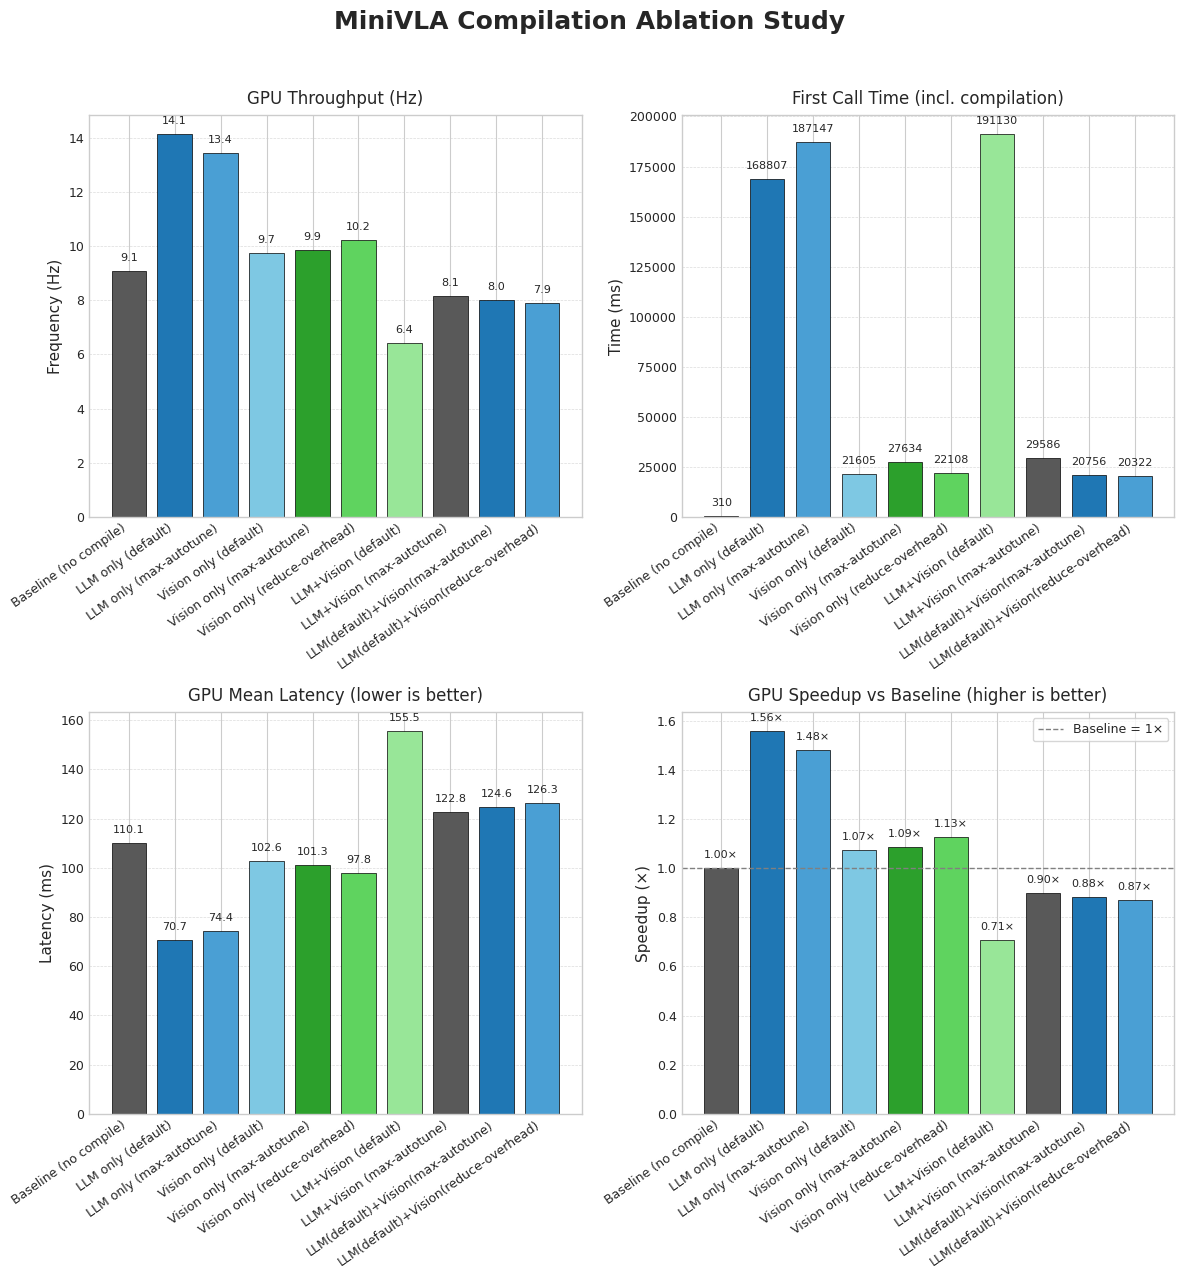

In [13]:
# Plotting
plt.style.use("seaborn-v0_8-whitegrid")

fig, axes = plt.subplots(2, 2, figsize=(12, 13))
fig.suptitle("MiniVLA Compilation Ablation Study", fontsize=18, fontweight="bold")

labels = [r["label"] for r in ablation_results]
x = np.arange(len(labels))
bar_width = 0.75

# Color scheme: baseline=gray, default=blue, max-autotune=green
colors = ["#595959", "#1f77b4", "#4a9fd4", "#7ec8e3", "#2ca02c", "#5fd35f", "#98e698"]

common_bar_kwargs = dict(width=bar_width, edgecolor="black", linewidth=0.5)

def format_axis(ax, title, ylabel, rotate=True):
    ax.set_title(title, fontsize=12, pad=8)
    ax.set_ylabel(ylabel, fontsize=11)
    ax.set_xticks(x)
    ax.set_xticklabels(labels, rotation=35 if rotate else 0, ha="right", fontsize=9)
    ax.tick_params(axis="y", labelsize=9)
    ax.grid(axis="y", linestyle="--", linewidth=0.5, alpha=0.7)

def add_value_labels(ax, bars, fmt="{:.1f}", offset=0.01):
    ylim = ax.get_ylim()
    span = ylim[1] - ylim[0]
    for bar in bars:
        val = bar.get_height()
        if val <= 0:
            continue
        ax.text(
            bar.get_x() + bar.get_width() / 2,
            val + span * offset,
            fmt.format(val),
            ha="center",
            va="bottom",
            fontsize=8,
            rotation=0,
        )

# # 1. Success Rate
# ax1 = axes[0, 0]
# success_rates = [r["success_rate"] * 100 for r in ablation_results]
# bars1 = ax1.bar(x, success_rates, color=colors[:len(x)], **common_bar_kwargs)
# format_axis(ax1, "Success Rate", "Success Rate (%)")
# ax1.set_ylim(0, 105)
# add_value_labels(ax1, bars1, fmt="{:.1f}", offset=0.02)

# 2. GPU Hz (Throughput)
ax2 = axes[0, 0]
gpu_hz = [r["gpu_stats"].get("hz", 0) if r["gpu_stats"] else 0 for r in ablation_results]
bars2 = ax2.bar(x, gpu_hz, color=colors[:len(x)], **common_bar_kwargs)
format_axis(ax2, "GPU Throughput (Hz)", "Frequency (Hz)")
add_value_labels(ax2, bars2, fmt="{:.1f}", offset=0.02)

# 3. Compilation Time
ax3 = axes[0, 1]
compile_times = [r.get("compilation_time_ms", 0) or 0 for r in ablation_results]
bars3 = ax3.bar(x, compile_times, color=colors[:len(x)], **common_bar_kwargs)
format_axis(ax3, "First Call Time (incl. compilation)", "Time (ms)")
add_value_labels(ax3, bars3, fmt="{:.0f}", offset=0.02)

# 4. GPU Mean Latency
ax4 = axes[1, 0]
gpu_mean = [r["gpu_stats"].get("mean_ms", 0) if r["gpu_stats"] else 0 for r in ablation_results]
bars4 = ax4.bar(x, gpu_mean, color=colors[:len(x)], **common_bar_kwargs)
format_axis(ax4, "GPU Mean Latency (lower is better)", "Latency (ms)")
add_value_labels(ax4, bars4, fmt="{:.1f}", offset=0.02)

# # 5. GPU P95 Latency
# ax5 = axes[2, 0]
# gpu_p95 = [r["gpu_stats"].get("p95_ms", 0) if r["gpu_stats"] else 0 for r in ablation_results]
# bars5 = ax5.bar(x, gpu_p95, color=colors[:len(x)], **common_bar_kwargs)
# format_axis(ax5, "GPU P95 Latency (lower is better)", "Latency (ms)")
# add_value_labels(ax5, bars5, fmt="{:.1f}", offset=0.02)

# 6. Speedup vs Baseline
ax6 = axes[1, 1]
baseline_gpu_mean = ablation_results[0]["gpu_stats"].get("mean_ms", 1) if ablation_results[0]["gpu_stats"] else 1
gpu_speedup = [
    baseline_gpu_mean / r["gpu_stats"].get("mean_ms", baseline_gpu_mean)
    if r["gpu_stats"] and r["gpu_stats"].get("mean_ms", 0) > 0 else 1.0
    for r in ablation_results
]
bars6 = ax6.bar(x, gpu_speedup, color=colors[:len(x)], **common_bar_kwargs)
ax6.axhline(y=1.0, color="gray", linestyle="--", linewidth=1, label="Baseline = 1×")
format_axis(ax6, "GPU Speedup vs Baseline (higher is better)", "Speedup (×)")
add_value_labels(ax6, bars6, fmt="{:.2f}×", offset=0.02)
ax6.legend(fontsize=9, loc="upper right", frameon=True)

plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.savefig("ablation_results.png", dpi=200, bbox_inches="tight")
plt.show()


/pub/scratch/aagouzoul/tmp/ipykernel_2843357/3776199682.py:9: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  bp1 = ax_gpu.boxplot(gpu_data, labels=gpu_labels, patch_artist=True)


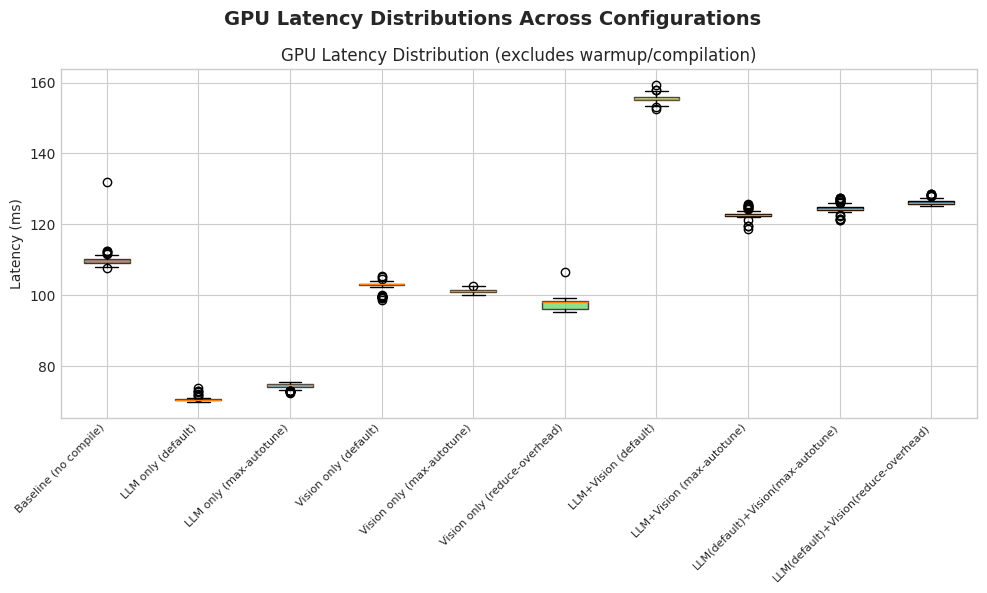

In [14]:
# Latency distribution plots (box plots)
fig2, ax_gpu = plt.subplots(figsize=(10, 6))
fig2.suptitle("GPU Latency Distributions Across Configurations", fontsize=14, fontweight="bold")

# GPU latency distributions
gpu_data = [r["all_policy_gpu_ms"] for r in ablation_results if r["all_policy_gpu_ms"]]
gpu_labels = [r["label"] for r in ablation_results if r["all_policy_gpu_ms"]]
if gpu_data:
    bp1 = ax_gpu.boxplot(gpu_data, labels=gpu_labels, patch_artist=True)
    for patch, color in zip(bp1["boxes"], colors[:len(gpu_data)]):
        patch.set_facecolor(color)
        patch.set_alpha(0.7)
    ax_gpu.set_ylabel("Latency (ms)")
    ax_gpu.set_title("GPU Latency Distribution (excludes warmup/compilation)")
    ax_gpu.tick_params(axis="x", rotation=45)
    for label in ax_gpu.get_xticklabels():
        label.set_ha("right")
        label.set_fontsize(8)

plt.tight_layout()
plt.savefig("ablation_latency_distributions.png", dpi=150, bbox_inches="tight")
plt.show()


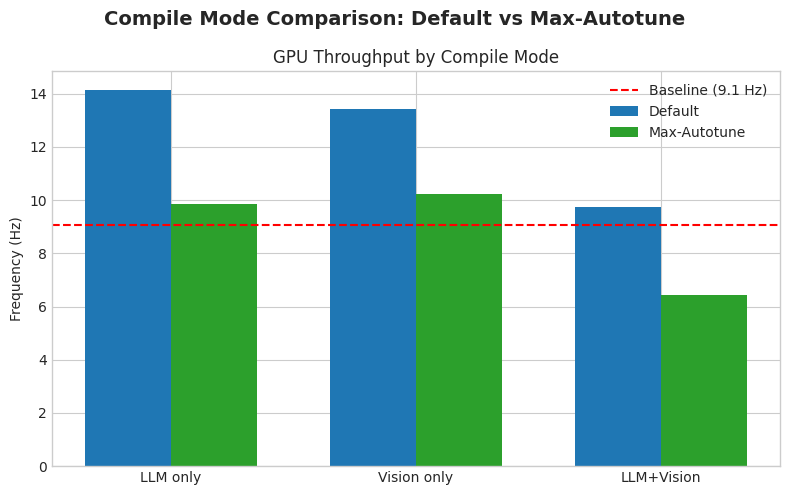

In [15]:
# Grouped comparison: Default vs Max-Autotune for each compile option
fig3, ax_c1 = plt.subplots(figsize=(8, 5))
fig3.suptitle("Compile Mode Comparison: Default vs Max-Autotune", fontsize=14, fontweight="bold")

compile_options = ["LLM only", "Vision only", "LLM+Vision"]
x_comp = np.arange(len(compile_options))
width = 0.35

# Extract data for comparison
default_gpu_hz = [ablation_results[1]["gpu_stats"].get("hz", 0),  # LLM only (default)
                  ablation_results[2]["gpu_stats"].get("hz", 0),  # Vision only (default)
                  ablation_results[3]["gpu_stats"].get("hz", 0)]  # LLM+Vision (default)

maxauto_gpu_hz = [ablation_results[4]["gpu_stats"].get("hz", 0),  # LLM only (max-autotune)
                  ablation_results[5]["gpu_stats"].get("hz", 0),  # Vision only (max-autotune)
                  ablation_results[6]["gpu_stats"].get("hz", 0)]  # LLM+Vision (max-autotune)

baseline_hz = ablation_results[0]["gpu_stats"].get("hz", 0) if ablation_results[0]["gpu_stats"] else 0

# GPU Hz comparison
bars_c1a = ax_c1.bar(x_comp - width/2, default_gpu_hz, width, label="Default", color="#1f77b4")
bars_c1b = ax_c1.bar(x_comp + width/2, maxauto_gpu_hz, width, label="Max-Autotune", color="#2ca02c")
ax_c1.axhline(y=baseline_hz, color="red", linestyle="--", linewidth=1.5, label=f"Baseline ({baseline_hz:.1f} Hz)")
ax_c1.set_ylabel("Frequency (Hz)")
ax_c1.set_title("GPU Throughput by Compile Mode")
ax_c1.set_xticks(x_comp)
ax_c1.set_xticklabels(compile_options)
ax_c1.legend()

plt.tight_layout()
plt.savefig("ablation_mode_comparison.png", dpi=150, bbox_inches="tight")
plt.show()


In [16]:
# Print final summary table
print("\n" + "=" * 100)
print("FINAL ABLATION SUMMARY")
print("=" * 100)
print(f"\n{'Configuration':<35} {'Success Rate':>12} {'GPU Hz':>10} {'GPU Speedup':>12} {'Compile (ms)':>14}")
print("-" * 100)

for i, r in enumerate(ablation_results):
    gpu_hz_val = r["gpu_stats"].get("hz", 0) if r["gpu_stats"] else 0
    gpu_spd = gpu_speedup[i]
    compile_ms = r.get("compilation_time_ms", 0) or 0
    print(f"{r['label']:<35} {r['success_rate']*100:>11.1f}% {gpu_hz_val:>10.2f} {gpu_spd:>11.2f}x {compile_ms:>14.1f}")

print("=" * 100)

# Best configuration
best_gpu_idx = np.argmax(gpu_hz_arr := [r["gpu_stats"].get("hz", 0) if r["gpu_stats"] else 0 for r in ablation_results])

print(f"\nBest GPU throughput: {ablation_results[best_gpu_idx]['label']} ({gpu_hz_arr[best_gpu_idx]:.2f} Hz)")



FINAL ABLATION SUMMARY

Configuration                       Success Rate     GPU Hz  GPU Speedup   Compile (ms)
----------------------------------------------------------------------------------------------------
Baseline (no compile)                     100.0%       9.08        1.00x          310.5
LLM only (default)                        100.0%      14.14        1.56x       168807.3
LLM only (max-autotune)                   100.0%      13.44        1.48x       187147.4
Vision only (default)                     100.0%       9.75        1.07x        21605.3
Vision only (max-autotune)                100.0%       9.87        1.09x        27634.5
Vision only (reduce-overhead)             100.0%      10.23        1.13x        22108.4
LLM+Vision (default)                      100.0%       6.43        0.71x       191129.8
LLM+Vision (max-autotune)                 100.0%       8.15        0.90x        29585.9
LLM(default)+Vision(max-autotune)         100.0%       8.03        0.88x        20

 # ABOVE RESULTS WERE WITH COMPILE ON VB DIRECTLY, CONTRARY TO BEFORE WHERE IT WAS APPLIED SEPARATELY